In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import re
from collections import Counter

# VEST OH 2020
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Ohio Secretary of State (https://www.sos.state.oh.us/elections/election-results-and-data/). 

#### Processing Part 1
The following counties include adjustments to account for corporate annexations that are not specified below by precinct: Adams, Athens, Butler, Franklin, Guernsey, Montgomery, Stark, Tuscarawas, Warren, Wayne.

#### Processing Part 2 (unclear whether this is for election results, shapefiles, or both)
The following additional revisions were made to match the 2020 precinct boundaries:

- **Athens:** Adjust Athens 4-4/4-5, Nelsonville 1/2/3/4
- **Brown:** Adjust Perry Twp South/Villages
- **Butler:** Adjust Hamilton 22/24, Oxford 6/11, Trenton 5/7, West Chester 28/39
- **Champaign:** Adjust Union N/S
- **Clark:** Align New Carlisle, Springfield precincts with county maps
- **Crawford:** Move eastern Polk Twp from Galion 1B to western Polk Twp
- **Cuyahoga:** Adjust Olmsted Twp D/F/H
- **Delaware:** Adjust Berlin C/Delaware 3-F
- **Fairfield:** Adjust Greenfield B/Lancaster 2-A, Pickerington F/Violet B/Violet C
- **Greene:** Adjust Bath 277/Fairborn 226/Xenia 351
- **Hamilton:** Adjust Cleves A/Whitewater A, Colerain BB/F
- **Knox:** Adjust Clinton A/Mount Vernon 1-B, Clinton B/Mount Vernon 2-A
- **Lake:** Adjust Painesville A/K
- **Medina:** Adjust Wadsworth City 1-D/Sharon D, Wadsworth City 2-D/Twp C
- **Richland:** Adjust Ontario 3/4
- **Stark:** Adjust Canton 8-C/Plain 6, Canton 6-A/Plain 12
- **Summit:** Adjust Coventry D/G, Hudson 1-B/3-C, Springfield F/J
- **Warren:** Adjust Mason City Z/Union A, South Lebanon A/B

#### Races
G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREGHAW - Howie Hawkins (Independent)  

### Shapefiles

#### Sources
Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release. Note that some VTDs were relabeled to match precinct names and/or precinct codes in the November 2020 general election returns.

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_oh_20 = gp.read_file("./raw-from-source/VEST/oh_2020/oh_2020.shp")

In [3]:
vest_oh_20.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

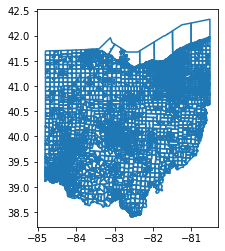

In [4]:
vest_oh_20.boundary.plot()

In [5]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for OH

In [6]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Ohio"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
oh_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Cleaned the `statewideresultsbyprecinct.xlsx` file by hand, and created `statewideresultsbyprecinct_clean.csv`. No modifications were made to the election results. Unnecessary tabs were removed and column names were renamed to match VEST's manually. 

In [7]:
#Load in clean SOS file
elections_2020_raw = pd.read_excel("./raw-from-source/SOS/statewideresultsbyprecinct.xlsx",sheet_name="Master")

In [8]:
def clean_oh_import(dataframe):
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col_name = dataframe.columns[index]
        col_name = col_name.replace("\n"," ")
        if "Unnamed" in col_name:
            corrected_col_names.append(corrected_col_names[index-1])
        else:
            corrected_col_names.append(col_name)
    dataframe.columns = corrected_col_names
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col = dataframe.columns[index]
        first_row = dataframe.iloc[0,index]
        if (index > 7):
            new_column_name = col + " " + first_row 
            corrected_col_names.append(new_column_name)
        else:
            corrected_col_names.append(first_row)
    dataframe.columns = corrected_col_names
    
    dataframe = dataframe.iloc[3:,]
    return dataframe

In [9]:
elections_2020 = clean_oh_import(elections_2020_raw)

In [10]:
elections_2020["COUNTYFP"] = elections_2020['County Name'].map(oh_fips_dict).fillna("n/a")

<ipython-input-10-d74292b25e12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elections_2020["COUNTYFP"] = elections_2020['County Name'].map(oh_fips_dict).fillna("n/a")


In [11]:


filter_out_cols = [i for i in elections_2020.columns if ("Judge of the Court of Appeals - District" in i or "Member of the State Board of Education - District" in i or "WI" in i)]

In [12]:
elections_2020 = elections_2020[[i for i in elections_2020.columns if i not in filter_out_cols]]

## Look into split precincts

In [13]:
def get_level_dist(column_name):
    if "Representative to Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
    else:
        raise ValueError
    return_val = re.findall("District \S{2}",column_name)    
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
    else:
        raise ValueError
    return level,dist

In [14]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [15]:
district_cols = [i for i in elections_2020.columns if "District" in i]
elections_2020_districts = elections_2020[['COUNTYFP','Precinct Name','Precinct Code']+district_cols]

In [16]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in elections_2020_districts.iterrows():
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["COUNTYFP"]+"-"+row["Precinct Code"]]=is_split
    precinct_mapping_dict[row["COUNTYFP"]+"-"+row["Precinct Code"]]=precinct_list


## Rename Columns

In [17]:
elections_2020.columns

keep_names = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','Ballots Counted','Official Voter Turnout','COUNTYFP']

In [18]:
def get_race(contest):
    if "Justice of the Supreme Court" in contest:
        level = "SSC"
        if "Kennedy" in contest or "O'Donnell" in contest:
            level = "SSCK"
        else:
            level = "SSCF"
    elif "President" in contest:
        level = "PRE"
    elif ("Representative to Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]
    else:
          raise ValueError
    return level

"Although elections for the Ohio Supreme Court are officially nonpartisan, they are preceded by a partisan primary."

In [19]:
def get_party(contest):
    if contest == "State Representative - District 30  Tom Roll":
        return "I"
    if "Justice of the Supreme Court Term" in contest:
        if "Sharon L. Kennedy" in contest:
            return "R"
        elif "John P. O'Donnell" in contest:
            return "D"
        elif "Jennifer Brunner" in contest:
            return "D"
        elif "Judi French" in contest:
            return "R"
        else:
            print(contest)
            raise ValueError
    return_val = re.findall("\(\S\)",contest)   
    if (len(return_val)!=0):
        party = return_val[0][1]
        return party
    else:
        print(contest)
        raise ValueError

In [20]:
def get_name(contest):
    contest = contest.upper()
    contest = contest.replace("'","")
    if ("(") in contest.split(" ")[-1]:
        second_to_last = contest.split(" ")[-2]
        #second_to_last = second_to_last.replace("'","")
        if second_to_last in ["JR","III"]:
            third_to_last = contest.split(" ")[-3]
            #third_to_last = third_to_last.replace("'","")
            return third_to_last[0:3]
        else:
            return second_to_last[0:3]
    else:
        return contest.split(" ")[-1][0:3] 

In [21]:
contest_name_change_dict = {
 'President and Vice President  Joseph R. Biden and Kamala D. Harris (D)':'G20PREDBID',
 'President and Vice President  Howie Hawkins and Angela Walker':'G20PREGHAW',
 'President and Vice President  Jo Jorgensen and Spike Cohen (L)':'G20PRELJOR',
 'President and Vice President  Donald J. Trump and Michael R. Pence (R)':'G20PRERTRU',
}

In [22]:
for contest in elections_2020.columns:
    if contest not in keep_names and "President" not in contest:
        contest_name_change_dict[contest] = "G"+get_race(contest)+get_party(contest)+get_name(contest)

In [23]:
elections_2020.rename(columns=contest_name_change_dict,inplace=True)

In [24]:
df = pd.DataFrame([(v, k) for k, v in contest_name_change_dict.items()], columns=['Candidate', 'Column'])
# Store the data into a csv file
df.to_csv('./cand_dicts/oh_gen_20_sldl_prec.csv', sep=',')

In [25]:
list(elections_2020.columns)

['County Name',
 'Precinct Name',
 'Precinct Code',
 'Region Name',
 'Media Market',
 'Registered Voters',
 'Ballots Counted',
 'Official Voter Turnout',
 'G20PREDBID',
 'G20PREGHAW',
 'G20PRELJOR',
 'G20PRERTRU',
 'GCON01RCHA',
 'GCON01LKAH',
 'GCON01DSCH',
 'GCON02DCAS',
 'GCON02RWEN',
 'GCON03DBEA',
 'GCON03RRIC',
 'GCON04DFRE',
 'GCON04RJOR',
 'GCON04LPER',
 'GCON05RLAT',
 'GCON05DRUB',
 'GCON06RJOH',
 'GCON06DROB',
 'GCON07RGIB',
 'GCON07LLAP',
 'GCON07DPOT',
 'GCON08RDAV',
 'GCON08DENO',
 'GCON09DKAP',
 'GCON09RWEB',
 'GCON10DTIM',
 'GCON10RTUR',
 'GCON11DFUD',
 'GCON11RGOR',
 'GCON12RBAL',
 'GCON12DSHE',
 'GCON12LSTE',
 'GCON13LFRI',
 'GCON13RHAG',
 'GCON13DRYA',
 'GCON14RJOY',
 'GCON14DMUE',
 'GCON15DNEW',
 'GCON15RSTI',
 'GCON16DGOD',
 'GCON16RGON',
 'GSU02RGAV',
 'GSU02DODO',
 'GSU04RLAN',
 'GSU04DWYE',
 'GSU06RANT',
 'GSU06DFOG',
 'GSU08RBLE',
 'GSU08DBRO',
 'GSU10DBAL',
 'GSU10RHAC',
 'GSU12RHUF',
 'GSU12DPOL',
 'GSU14RJOH',
 'GSU14DOTT',
 'GSU16RKUN',
 'GSU16DLET',
 'GSU18

### Filter Down to Relevant Columns

In [26]:
keeper_columns = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','Ballots Counted','Official Voter Turnout','COUNTYFP']
state_house_contests = [i for i in list(elections_2020.columns) if "GSL" in i]

In [27]:
elections_2020 = elections_2020[keeper_columns+state_house_contests]

### Compare Precinct Totals

In [28]:
elections_2020["UNIQUE_ID"] = elections_2020["COUNTYFP"]+"-"+elections_2020["Precinct Code"]
vest_oh_20["UNIQUE_ID"] = vest_oh_20["COUNTYFP20"]+"-"+vest_oh_20["PRECINCT20"]

***Issue merging SLDL:  85 and prec: 091-AAS ***
***Issue merging SLDL:  94 and prec: 167-ACD ***
***Issue merging SLDL:  22 and prec: 049-AYU ***
***Issue merging SLDL:  26 and prec: 049-AXI ***
***Issue merging SLDL:  24 and prec: 049-ADF ***
***Issue merging SLDL:  20 and prec: 049-BIQ ***
***Issue merging SLDL:  25 and prec: 049-AIJ ***
***Issue merging SLDL:  25 and prec: 049-AIL ***
***Issue merging SLDL:  26 and prec: 049-AUK ***
***Issue merging SLDL:  20 and prec: 049-BIK ***
***Issue merging SLDL:  17 and prec: 049-AZG ***
***Issue merging SLDL:  22 and prec: 049-AVN ***
***Issue merging SLDL:  20 and prec: 049-ASN ***
***Issue merging SLDL:  24 and prec: 049-AGW ***
***Issue merging SLDL:  24 and prec: 049-AGY ***
***Issue merging SLDL:  17 and prec: 049-BBO ***
***Issue merging SLDL:  49 and prec: 151-ANX ***
***Issue merging SLDL:  53 and prec: 017-ACG ***
***Issue merging SLDL:  23 and prec: 049-AYR ***
***Issue merging SLDL:  24 and prec: 049-AGX ***

In [29]:
pd.options.display.max_columns = 999

In [30]:
elections_2020[elections_2020["UNIQUE_ID"] == "049-AGW"]

,County Name,Precinct Name,Precinct Code,Region Name,Media Market,Registered Voters,Ballots Counted,Official Voter Turnout,COUNTYFP,GSL01DTHE,GSL01RWIG,GSL02DGRA,GSL02RJOH,GSL03RGHA,GSL03DJOH,GSL04RCUP,GSL05RGIN,GSL05DWIN,GSL06RHAW,GSL06DROB,GSL07RPAT,GSL07DSWE,GSL08DSMI,GSL09DBOY,GSL09RRUS,GSL10DUPC,GSL11DHOW,GSL12DBRE,GSL12RPOW,GSL13RHAR,GSL13DSKI,GSL14RMCM,GSL14DSWE,GSL15DCRO,GSL15RKUS,GSL16RGRE,GSL16DSMI,GSL17RHAS,GSL17DMIL,GSL18DBOG,GSL18RPAC,GSL19RFRE,GSL19DLIG,GSL20RBAE,GSL20DBRO,GSL21RCOO,GSL21DLIS,GSL22DLEL,GSL23DDAY,GSL23RLAN,GSL24RMAN,GSL24DRUS,GSL25RBUR,GSL25DJAR,GSL26DCRA,GSL27DBIT,GSL27RBRI,GSL28DMIR,GSL28RMON,GSL29RABR,GSL30IROL,GSL30RSEI,GSL31DKEL,GSL32DING,GSL33DDEN,GSL33RHIL,GSL34DSYK,GSL34RTOD,GSL35DGAL,GSL35RSAR,GSL36DSHA,GSL36RYOU,GSL37RBIG,GSL37DWEI,GSL38DCAM,GSL38RROE,GSL39DBLA,GSL39RMUL,GSL40DJAC,GSL40RPLU,GSL41DBER,GSL41RWHI,GSL42RYOU,GSL43DCOX,GSL43RCRE,GSL44DHIC,GSL44RMCM,GSL45RLOG,GSL45DSOB,GSL46RSAL,GSL46DSHE,GSL47DLAR,GSL47RMER,GSL48ROEL,GSL49RHAA,GSL49DWES,GSL50DSIM,GSL50RSTO,GSL51RCAR,GSL52RGRO,GSL52DHOR,GSL53RHAL,GSL53DNOV,GSL54DSHO,GSL54RZEL,GSL55RMAN,GSL55DSTE,GSL56RLAC,GSL56DMIL,GSL57DADK,GSL57RSTE,GSL58DHAG,GSL58RSIM,GSL59RCUT,GSL59DSTA,GSL60RPHI,GSL60DTRO,GSL61RCAL,GSL61DDUD,GSL62RLIP,GSL62DROS,GSL63DBLA,GSL63RLOY,GSL64DOBR,GSL64RYOD,GSL65DDAR,GSL65RSCH,GSL66RBIR,GSL67RJOR,GSL67DMOR,GSL68RCAR,GSL68DMOU,GSL69DBEH,GSL69RRAY,GSL70DBAR,GSL70RKIC,GSL71DCAR,GSL71RFRA,GSL72RHOU,GSL73RLAM,GSL73DMCC,GSL74RDEA,GSL75DCLI,GSL75RPAV,GSL76RGRE,GSL76DWES,GSL77RLAR,GSL77DWIL,GSL78DOWE,GSL78RSTE,GSL79RKOE,GSL79DRIC,GSL80DJON,GSL80RPOW,GSL81RHOO,GSL82RRIE,GSL83RCRO,GSL84RMAN,GSL84DMON,GSL85RVIT,GSL86RRIC,GSL86DROB,GSL87DBAR,GSL87RMCC,GSL88RCLI,GSL88DLIE,GSL89DMIL,GSL89RSWE,GSL90RBAL,GSL91DDAI,GSL91RWIL,GSL92RJOH,GSL92DWOR,GSL93RSTE,GSL94REDW,GSL94DONE,GSL95RJON,GSL96RFER,GSL96LHER,GSL96DOLI,GSL97RHOL,GSL97DSWO,GSL98DBEE,GSL98RHIL,GSL99DDAN,GSL99RART,UNIQUE_ID
2791,Franklin,COLS 33-B,AGW,Central,Columbus,1106,781,0.706148,049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,600,138,0,0,0,0,0,0,0,0,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,049-AGW


In [31]:
vest_oh_20[vest_oh_20["VTDST20"]=="025ADF"]

,STATEFP20,COUNTYFP20,VTDST20,PRECINCT20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,geometry,UNIQUE_ID
6955,39,049,025ADF,ADF,39049025ADF,COLS 15-B,193,527,10,0,"POLYGON ((-83.04721 40.01903, -83.04702 40.021...",049-ADF


<AxesSubplot:>

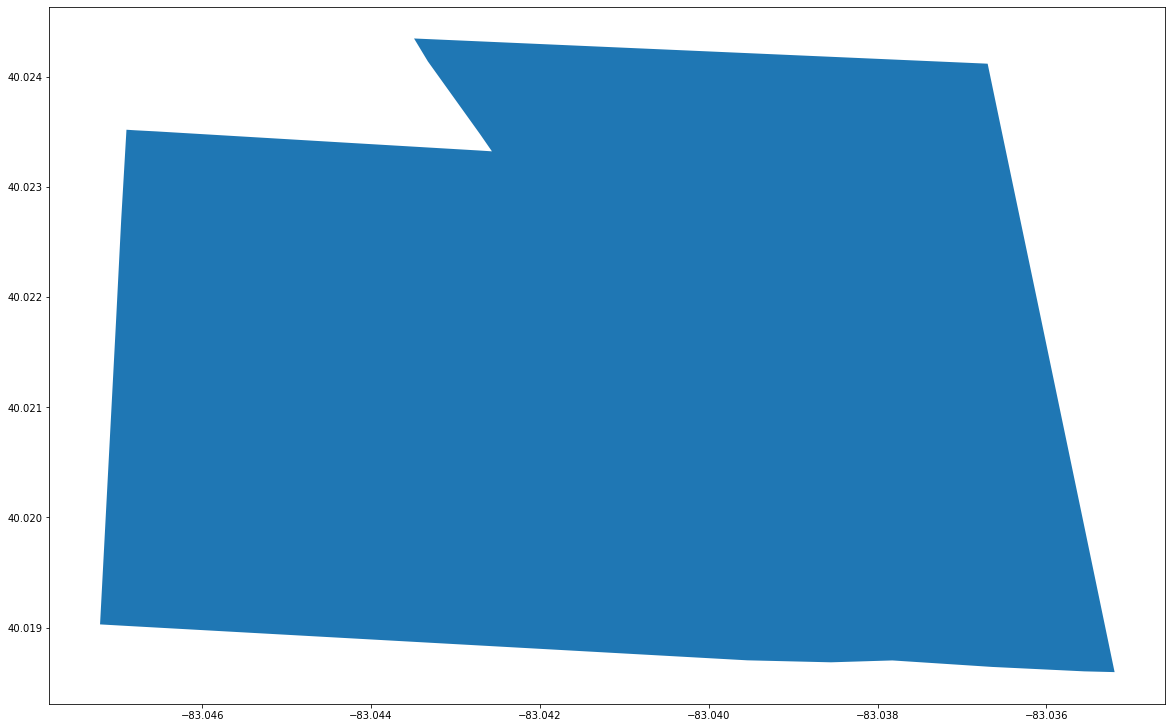

In [32]:
vest_oh_20[vest_oh_20["VTDST20"]=="025ADF"].plot(figsize=(20,20))

In [33]:
#Confirm unique IDs are unique
print(elections_2020["UNIQUE_ID"].value_counts(dropna=False))
print(vest_oh_20["UNIQUE_ID"].value_counts(dropna=False))

155-ABF    1
153-AGW    1
023-ACT    1
093-AHO    1
071-AAV    1
          ..
117-AAM    1
033-ABT    1
035-CRK    1
035-CGF    1
083-AAC    1
Name: UNIQUE_ID, Length: 8933, dtype: int64
155-ABF    1
095-AQP    1
041-ADA    1
109-ACF    1
101-AAP    1
          ..
061-AAM    1
049-AHY    1
035-BLS    1
035-BYC    1
083-AAC    1
Name: UNIQUE_ID, Length: 8941, dtype: int64


In [34]:
global attempt_one
attempt_one = pd.merge(vest_oh_20,elections_2020,how="outer",on="UNIQUE_ID",indicator=True)
print(attempt_one["_merge"].value_counts())

vest_only = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only = attempt_one[attempt_one["_merge"]=="right_only"]

both          8933
left_only        8
right_only       0
Name: _merge, dtype: int64


In [35]:
#Confirm these are all zero-vote races
races =["UNIQUE_ID"]

for val in ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR','G20PREGHAW']:
    races.append(val)

print((vest_only[races]))

     UNIQUE_ID  G20PRERTRU  G20PREDBID  G20PRELJOR  G20PREGHAW
814    093-ZZZ           0           0           0           0
982    123-ZZZ           0           0           0           0
2924   095-ZZZ           0           0           0           0
3674   043-ZZZ           0           0           0           0
4389   085-ZZZ           0           0           0           0
4565   035-ZZZ           0           0           0           0
5357   133-ZZZ           0           0           0           0
7951   007-ZZZ           0           0           0           0


## Perform Splits

In [36]:
def return_sll_splits(split_dict):
    for val in split_dict.keys():
        if 'SL' in val:
            return split_dict['SL']

In [37]:
sll_splits_dict = {i:return_sll_splits(split_precincts_list[i]) for i in split_precincts_list.keys() if return_sll_splits(split_precincts_list[i]) != None }

#### Load in the shapefile

In [38]:
oh_sll_districts = gp.read_file("./raw-from-source/District_Shapefiles/oh_pl2020_sldl/oh_pl2020_sldl.shp")

In [39]:
oh_sll_districts.drop(['STATEFP20', 'GEOID20'], axis = 1, inplace = True)

In [40]:
oh_sll_districts = oh_sll_districts.to_crs(vest_oh_20.crs)
oh_sll_districts["SLDLST"] = oh_sll_districts["SLDLST20"].str[1:3]

In [41]:
list(attempt_one.columns)

['STATEFP20',
 'COUNTYFP20',
 'VTDST20',
 'PRECINCT20',
 'GEOID20',
 'NAME20',
 'G20PRERTRU',
 'G20PREDBID',
 'G20PRELJOR',
 'G20PREGHAW',
 'geometry',
 'UNIQUE_ID',
 'County Name',
 'Precinct Name',
 'Precinct Code',
 'Region Name',
 'Media Market',
 'Registered Voters',
 'Ballots Counted',
 'Official Voter Turnout',
 'COUNTYFP',
 'GSL01DTHE',
 'GSL01RWIG',
 'GSL02DGRA',
 'GSL02RJOH',
 'GSL03RGHA',
 'GSL03DJOH',
 'GSL04RCUP',
 'GSL05RGIN',
 'GSL05DWIN',
 'GSL06RHAW',
 'GSL06DROB',
 'GSL07RPAT',
 'GSL07DSWE',
 'GSL08DSMI',
 'GSL09DBOY',
 'GSL09RRUS',
 'GSL10DUPC',
 'GSL11DHOW',
 'GSL12DBRE',
 'GSL12RPOW',
 'GSL13RHAR',
 'GSL13DSKI',
 'GSL14RMCM',
 'GSL14DSWE',
 'GSL15DCRO',
 'GSL15RKUS',
 'GSL16RGRE',
 'GSL16DSMI',
 'GSL17RHAS',
 'GSL17DMIL',
 'GSL18DBOG',
 'GSL18RPAC',
 'GSL19RFRE',
 'GSL19DLIG',
 'GSL20RBAE',
 'GSL20DBRO',
 'GSL21RCOO',
 'GSL21DLIS',
 'GSL22DLEL',
 'GSL23DDAY',
 'GSL23RLAN',
 'GSL24RMAN',
 'GSL24DRUS',
 'GSL25RBUR',
 'GSL25DJAR',
 'GSL26DCRA',
 'GSL27DBIT',
 'GSL27RB

In [42]:
final_races = ['GSL01DTHE',
 'GSL01RWIG',
 'GSL02DGRA',
 'GSL02RJOH',
 'GSL03RGHA',
 'GSL03DJOH',
 'GSL04RCUP',
 'GSL05RGIN',
 'GSL05DWIN',
 'GSL06RHAW',
 'GSL06DROB',
 'GSL07RPAT',
 'GSL07DSWE',
 'GSL08DSMI',
 'GSL09DBOY',
 'GSL09RRUS',
 'GSL10DUPC',
 'GSL11DHOW',
 'GSL12DBRE',
 'GSL12RPOW',
 'GSL13RHAR',
 'GSL13DSKI',
 'GSL14RMCM',
 'GSL14DSWE',
 'GSL15DCRO',
 'GSL15RKUS',
 'GSL16RGRE',
 'GSL16DSMI',
 'GSL17RHAS',
 'GSL17DMIL',
 'GSL18DBOG',
 'GSL18RPAC',
 'GSL19RFRE',
 'GSL19DLIG',
 'GSL20RBAE',
 'GSL20DBRO',
 'GSL21RCOO',
 'GSL21DLIS',
 'GSL22DLEL',
 'GSL23DDAY',
 'GSL23RLAN',
 'GSL24RMAN',
 'GSL24DRUS',
 'GSL25RBUR',
 'GSL25DJAR',
 'GSL26DCRA',
 'GSL27DBIT',
 'GSL27RBRI',
 'GSL28DMIR',
 'GSL28RMON',
 'GSL29RABR',
 'GSL30IROL',
 'GSL30RSEI',
 'GSL31DKEL',
 'GSL32DING',
 'GSL33DDEN',
 'GSL33RHIL',
 'GSL34DSYK',
 'GSL34RTOD',
 'GSL35DGAL',
 'GSL35RSAR',
 'GSL36DSHA',
 'GSL36RYOU',
 'GSL37RBIG',
 'GSL37DWEI',
 'GSL38DCAM',
 'GSL38RROE',
 'GSL39DBLA',
 'GSL39RMUL',
 'GSL40DJAC',
 'GSL40RPLU',
 'GSL41DBER',
 'GSL41RWHI',
 'GSL42RYOU',
 'GSL43DCOX',
 'GSL43RCRE',
 'GSL44DHIC',
 'GSL44RMCM',
 'GSL45RLOG',
 'GSL45DSOB',
 'GSL46RSAL',
 'GSL46DSHE',
 'GSL47DLAR',
 'GSL47RMER',
 'GSL48ROEL',
 'GSL49RHAA',
 'GSL49DWES',
 'GSL50DSIM',
 'GSL50RSTO',
 'GSL51RCAR',
 'GSL52RGRO',
 'GSL52DHOR',
 'GSL53RHAL',
 'GSL53DNOV',
 'GSL54DSHO',
 'GSL54RZEL',
 'GSL55RMAN',
 'GSL55DSTE',
 'GSL56RLAC',
 'GSL56DMIL',
 'GSL57DADK',
 'GSL57RSTE',
 'GSL58DHAG',
 'GSL58RSIM',
 'GSL59RCUT',
 'GSL59DSTA',
 'GSL60RPHI',
 'GSL60DTRO',
 'GSL61RCAL',
 'GSL61DDUD',
 'GSL62RLIP',
 'GSL62DROS',
 'GSL63DBLA',
 'GSL63RLOY',
 'GSL64DOBR',
 'GSL64RYOD',
 'GSL65DDAR',
 'GSL65RSCH',
 'GSL66RBIR',
 'GSL67RJOR',
 'GSL67DMOR',
 'GSL68RCAR',
 'GSL68DMOU',
 'GSL69DBEH',
 'GSL69RRAY',
 'GSL70DBAR',
 'GSL70RKIC',
 'GSL71DCAR',
 'GSL71RFRA',
 'GSL72RHOU',
 'GSL73RLAM',
 'GSL73DMCC',
 'GSL74RDEA',
 'GSL75DCLI',
 'GSL75RPAV',
 'GSL76RGRE',
 'GSL76DWES',
 'GSL77RLAR',
 'GSL77DWIL',
 'GSL78DOWE',
 'GSL78RSTE',
 'GSL79RKOE',
 'GSL79DRIC',
 'GSL80DJON',
 'GSL80RPOW',
 'GSL81RHOO',
 'GSL82RRIE',
 'GSL83RCRO',
 'GSL84RMAN',
 'GSL84DMON',
 'GSL85RVIT',
 'GSL86RRIC',
 'GSL86DROB',
 'GSL87DBAR',
 'GSL87RMCC',
 'GSL88RCLI',
 'GSL88DLIE',
 'GSL89DMIL',
 'GSL89RSWE',
 'GSL90RBAL',
 'GSL91DDAI',
 'GSL91RWIL',
 'GSL92RJOH',
 'GSL92DWOR',
 'GSL93RSTE',
 'GSL94REDW',
 'GSL94DONE',
 'GSL95RJON',
 'GSL96RFER',
 'GSL96LHER',
 'GSL96DOLI',
 'GSL97RHOL',
 'GSL97DSWO',
 'GSL98DBEE',
 'GSL98RHIL',
 'GSL99DDAN',
 'GSL99RART']

In [43]:
for val in final_races:
    attempt_one[val] = attempt_one[val].fillna(0)
    attempt_one[val] = attempt_one[val].astype(int)
    print(val, sum(attempt_one[val]))

GSL01DTHE 15836
GSL01RWIG 36730
GSL02DGRA 16440
GSL02RJOH 41102
GSL03RGHA 37677
GSL03DJOH 27094
GSL04RCUP 38882
GSL05RGIN 36243
GSL05DWIN 12554
GSL06RHAW 35982
GSL06DROB 37995
GSL07RPAT 37493
GSL07DSWE 26922
GSL08DSMI 41159
GSL09DBOY 50894
GSL09RRUS 7868
GSL10DUPC 28453
GSL11DHOW 27346
GSL12DBRE 43247
GSL12RPOW 9342
GSL13RHAR 11621
GSL13DSKI 33647
GSL14RMCM 19643
GSL14DSWE 27618
GSL15DCRO 24020
GSL15RKUS 22018
GSL16RGRE 34075
GSL16DSMI 35013
GSL17RHAS 16588
GSL17DMIL 21664
GSL18DBOG 45861
GSL18RPAC 13007
GSL19RFRE 32950
GSL19DLIG 42267
GSL20RBAE 24928
GSL20DBRO 36330
GSL21RCOO 32756
GSL21DLIS 42990
GSL22DLEL 45754
GSL23DDAY 27532
GSL23RLAN 34275
GSL24RMAN 31202
GSL24DRUS 42935
GSL25RBUR 8870
GSL25DJAR 41312
GSL26DCRA 45350
GSL27DBIT 33339
GSL27RBRI 37723
GSL28DMIR 35353
GSL28RMON 33039
GSL29RABR 43320
GSL30IROL 16426
GSL30RSEI 42269
GSL31DKEL 42180
GSL32DING 42055
GSL33DDEN 41500
GSL33RHIL 13901
GSL34DSYK 36251
GSL34RTOD 10926
GSL35DGAL 22341
GSL35RSAR 17210
GSL36DSHA 29441
GSL36RYOU 3

In [44]:
global global_precinct_differences_dict
global_precinct_differences_dict = {}

In [45]:
def cd_splits(cd_list,level,old_name):
    global attempt_one
    full_shape = attempt_one.loc[attempt_one["UNIQUE_ID"]==old_name]
    #print(old_name,"->"," & ".join(new_id_list))
    for index in range(0,len(cd_list)):
        cd = oh_sll_districts.loc[oh_sll_districts["SLDLST"]==cd_list[index]]
        new_prec = gp.overlay(full_shape, cd, how='intersection',keep_geom_type=True)
        if(new_prec.empty):
            print("***Issue merging SLDL: ",cd_list[index],"and prec:",old_name,"***")
            ax = full_shape.plot(figsize = (20,20))
            cd.boundary.plot(ax = ax, color = "red")
            ax.set_title(old_name)
            for column in new_prec:
                if column in final_races and cd_list[index] in column:
                    print(column)
                    print(full_shape[column])
                    if column in global_precinct_differences_dict.keys():
                        global_precinct_differences_dict[column] += full_shape[column].values[0]
                    else:
                        global_precinct_differences_dict[column] = full_shape[column].values[0]
        new_prec = new_prec[list(attempt_one.columns)]
        for column in new_prec:
            if column in final_races and cd_list[index] not in column:
                new_prec.loc[0:,column] = 0 
        new_prec["UNIQUE_ID"]=old_name+"-("+level+"-"+cd_list[index]+")"
        attempt_one=attempt_one.append(new_prec)
        attempt_one.reset_index(drop=True,inplace=True)        
    #Remove the precinct that was split
    attempt_one=attempt_one[attempt_one["UNIQUE_ID"]!=old_name]
    attempt_one.reset_index(drop=True,inplace=True)

***Issue merging SLDL:  85 and prec: 091-AAS ***
GSL85RVIT
2591    14
Name: GSL85RVIT, dtype: int64
***Issue merging SLDL:  94 and prec: 167-ACD ***
GSL94REDW
5765    1
Name: GSL94REDW, dtype: int64
GSL94DONE
5765    7
Name: GSL94DONE, dtype: int64
***Issue merging SLDL:  22 and prec: 049-AYU ***
GSL22DLEL
6638    12
Name: GSL22DLEL, dtype: int64
***Issue merging SLDL:  26 and prec: 049-AXI ***
GSL26DCRA
6781    12
Name: GSL26DCRA, dtype: int64
***Issue merging SLDL:  24 and prec: 049-ADF ***
GSL24RMAN
6890    10
Name: GSL24RMAN, dtype: int64
GSL24DRUS
6890    25
Name: GSL24DRUS, dtype: int64
***Issue merging SLDL:  20 and prec: 049-BIQ ***
GSL20RBAE
6911    2
Name: GSL20RBAE, dtype: int64
GSL20DBRO
6911    0
Name: GSL20DBRO, dtype: int64
***Issue merging SLDL:  25 and prec: 049-AIJ ***
GSL25RBUR
6972    6
Name: GSL25RBUR, dtype: int64
GSL25DJAR
6972    15
Name: GSL25DJAR, dtype: int64
***Issue merging SLDL:  25 and prec: 049-AIL ***
GSL25RBUR
6987    20
Name: GSL25RBUR, dtype: int64
G

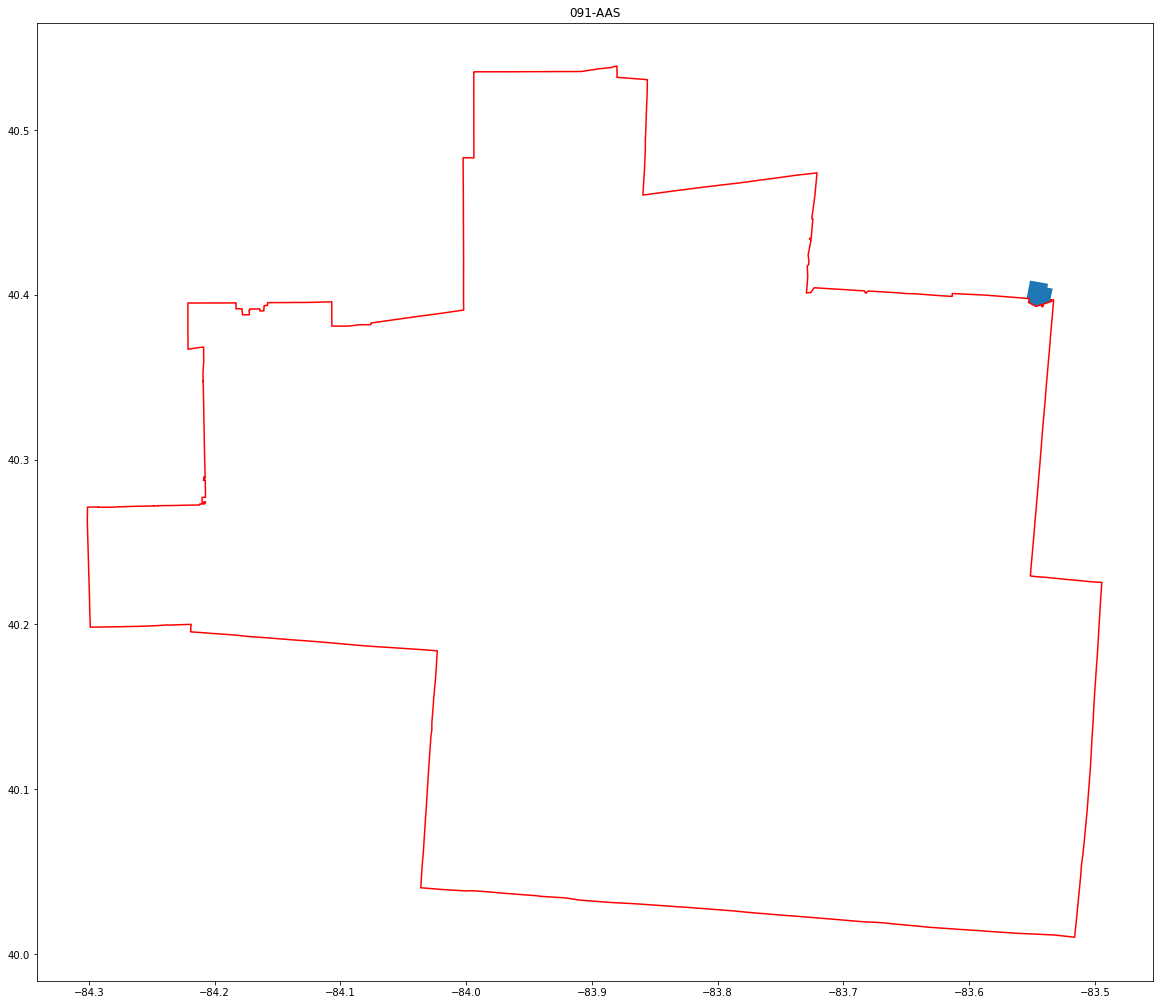

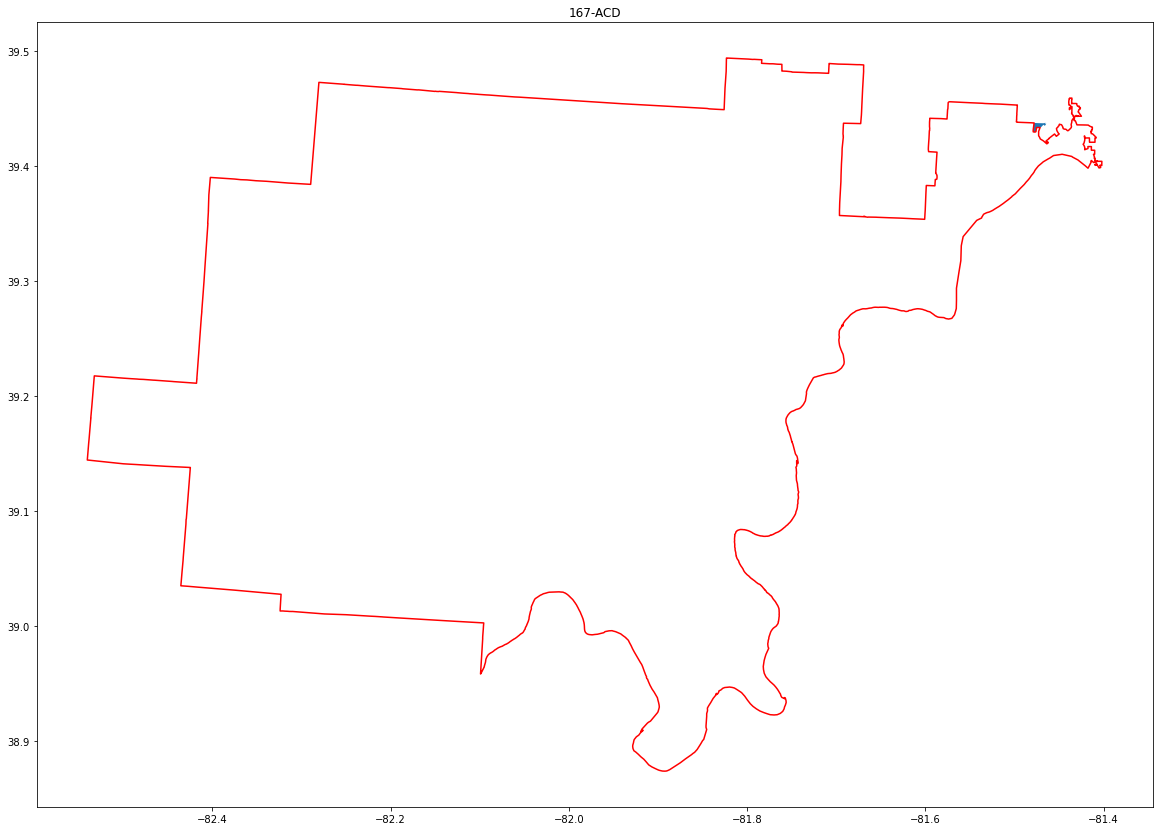

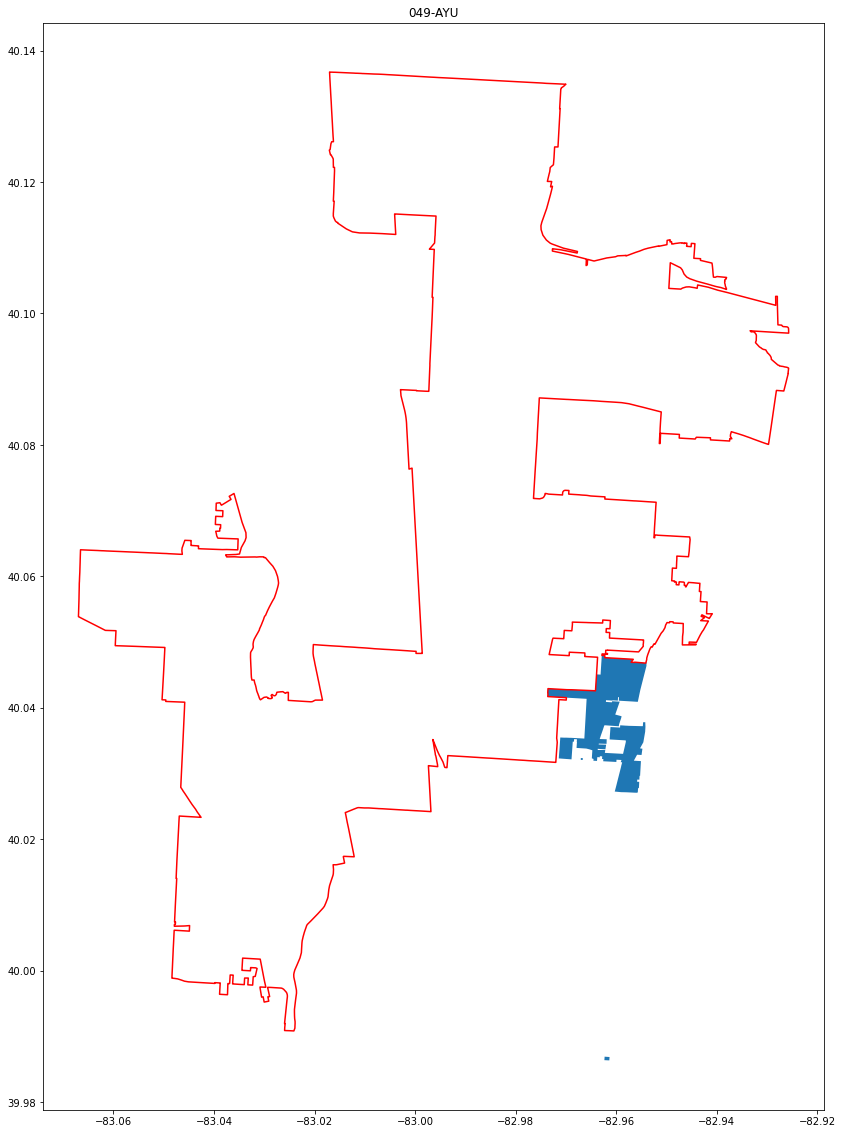

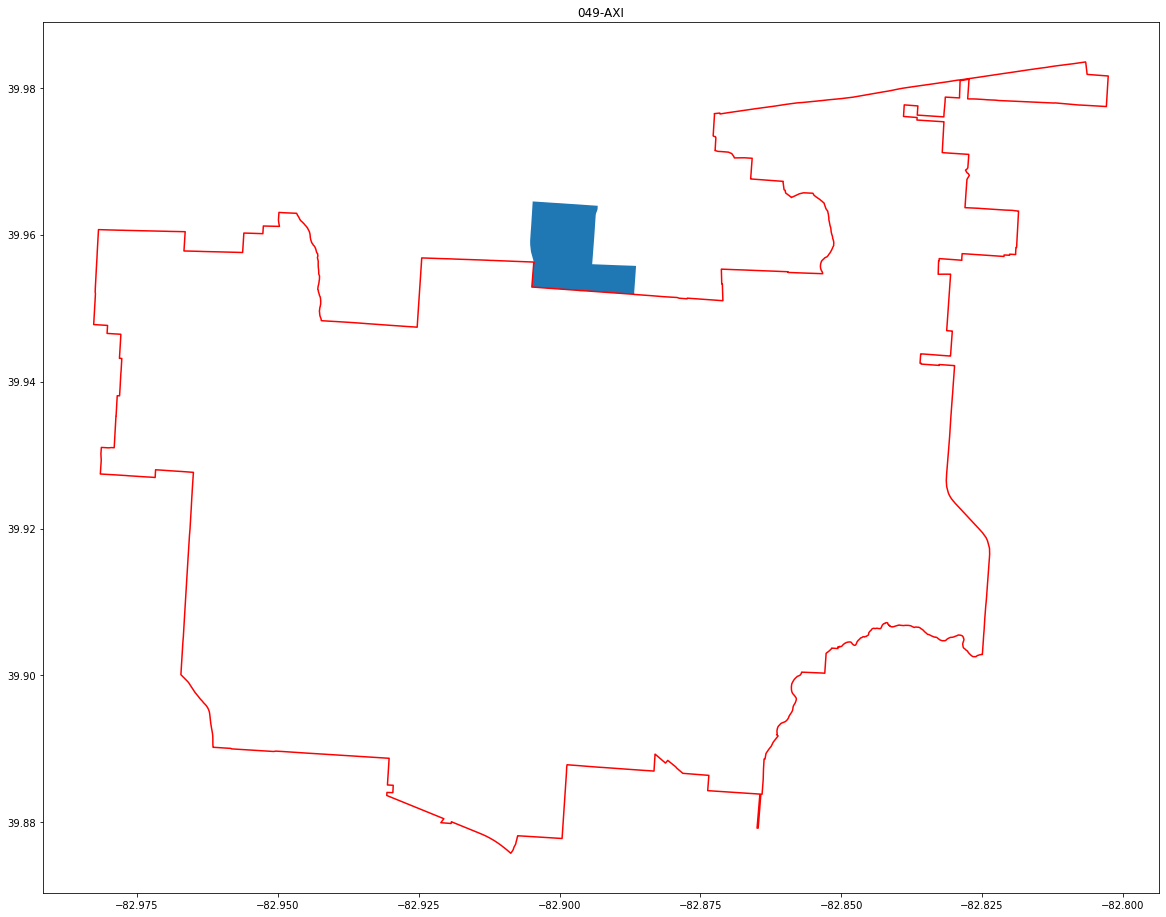

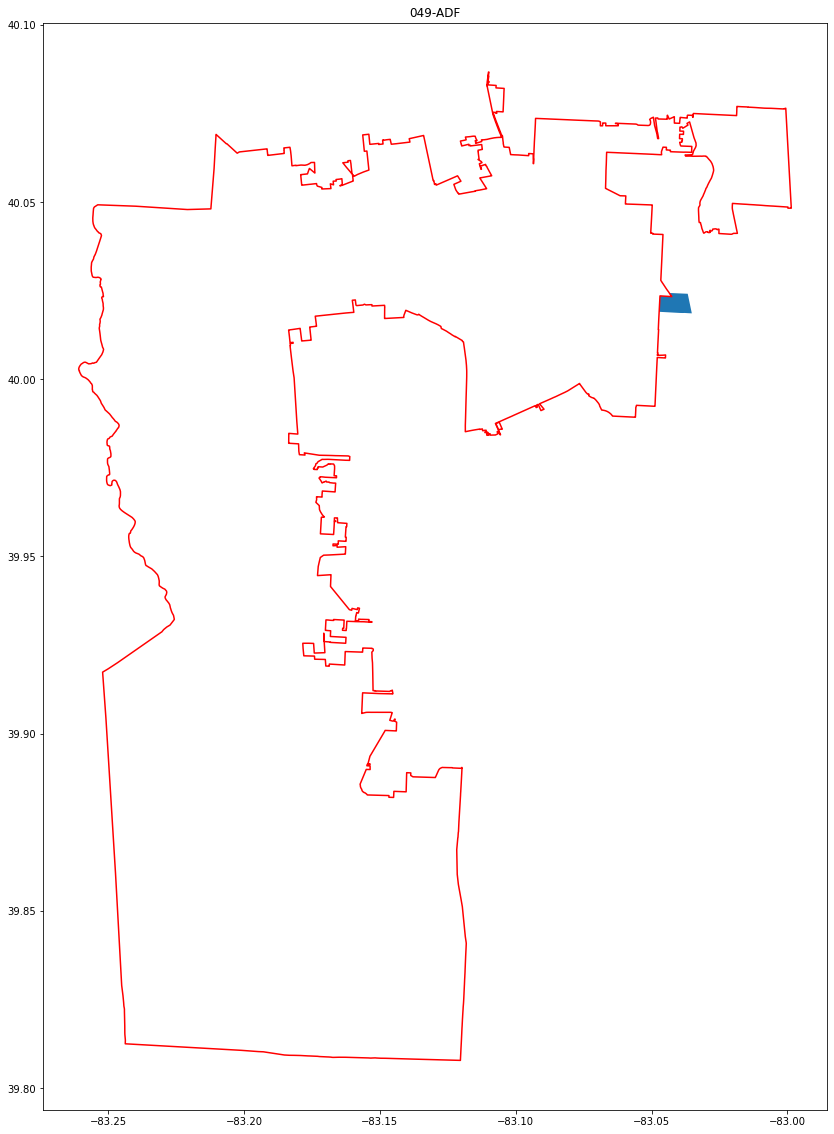

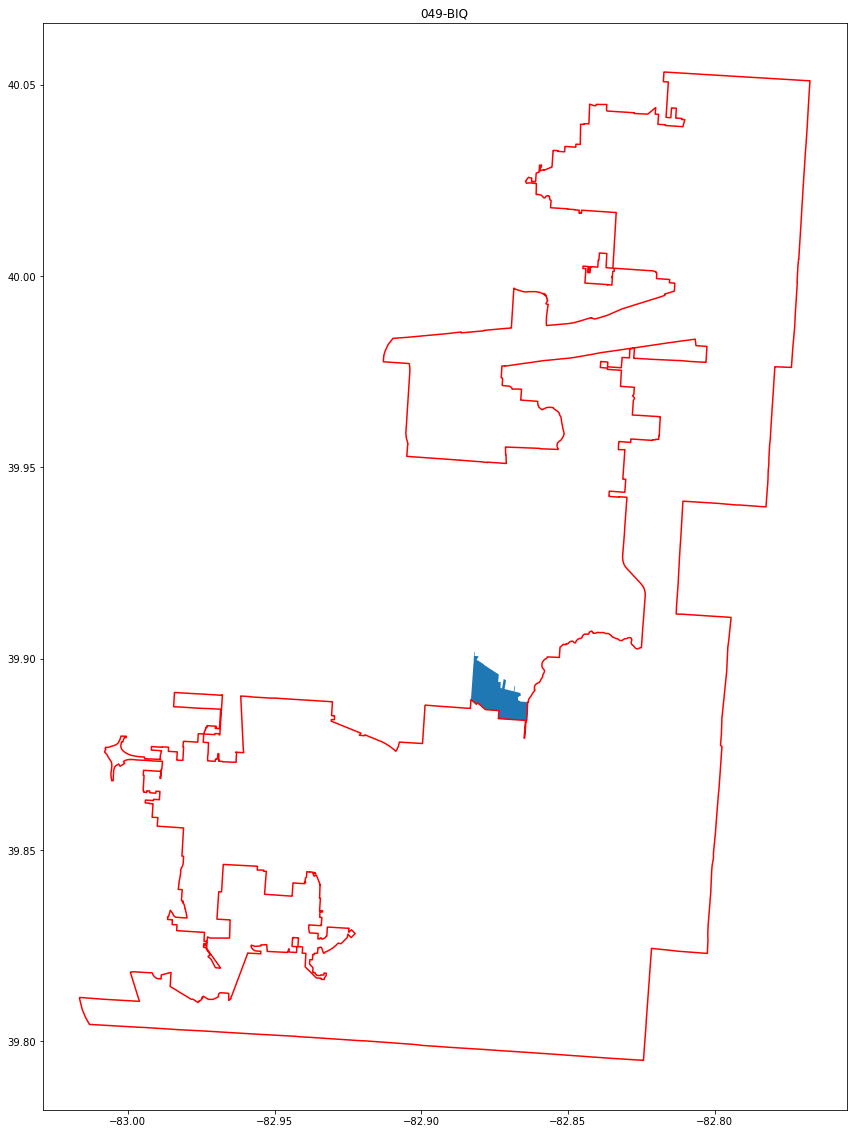

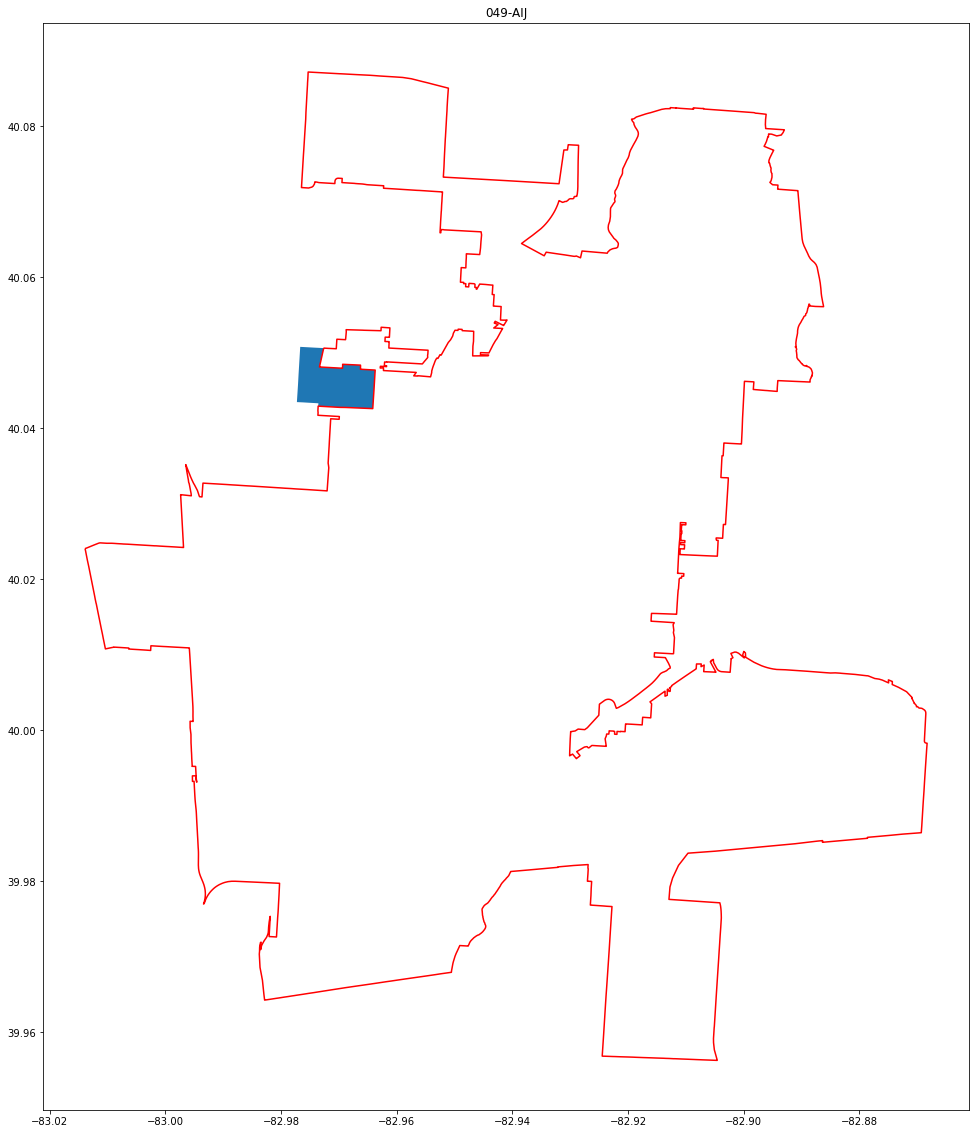

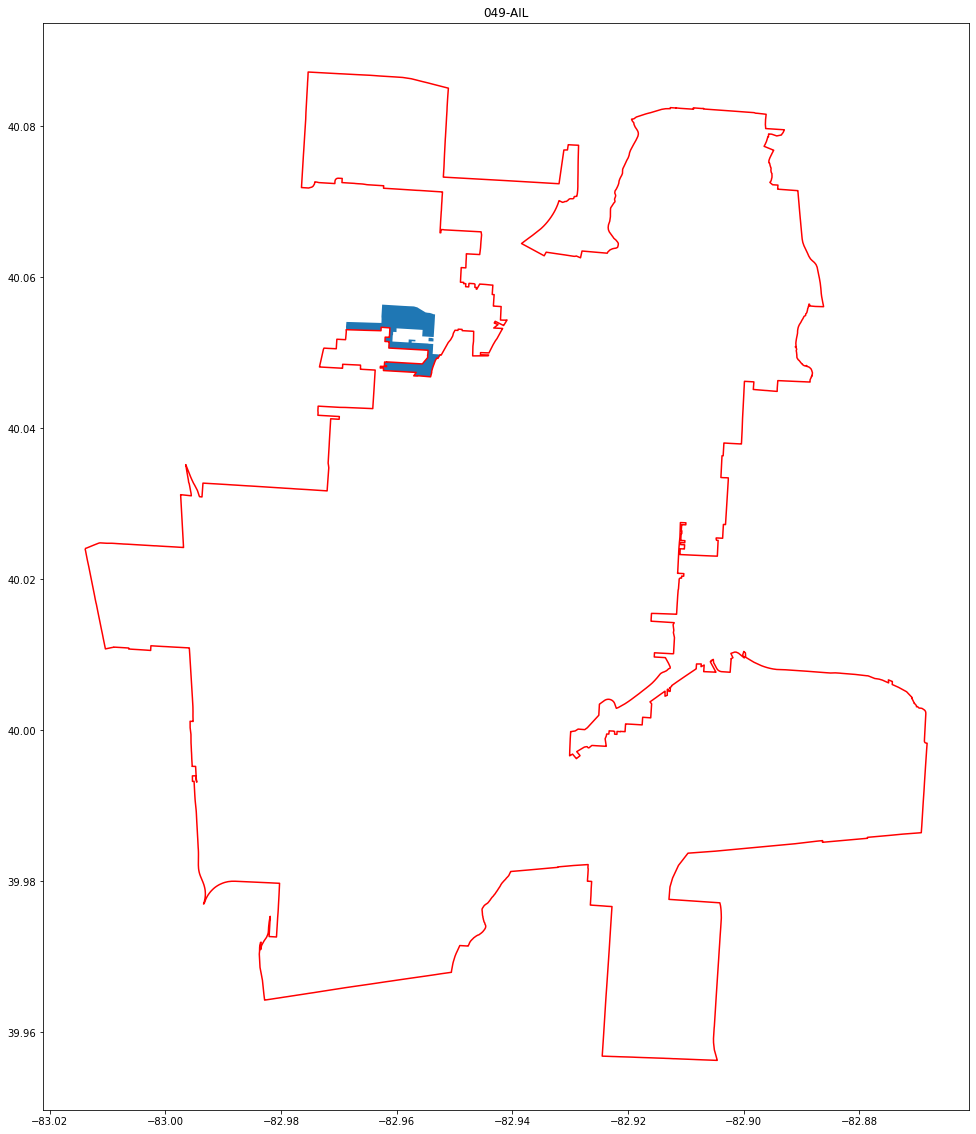

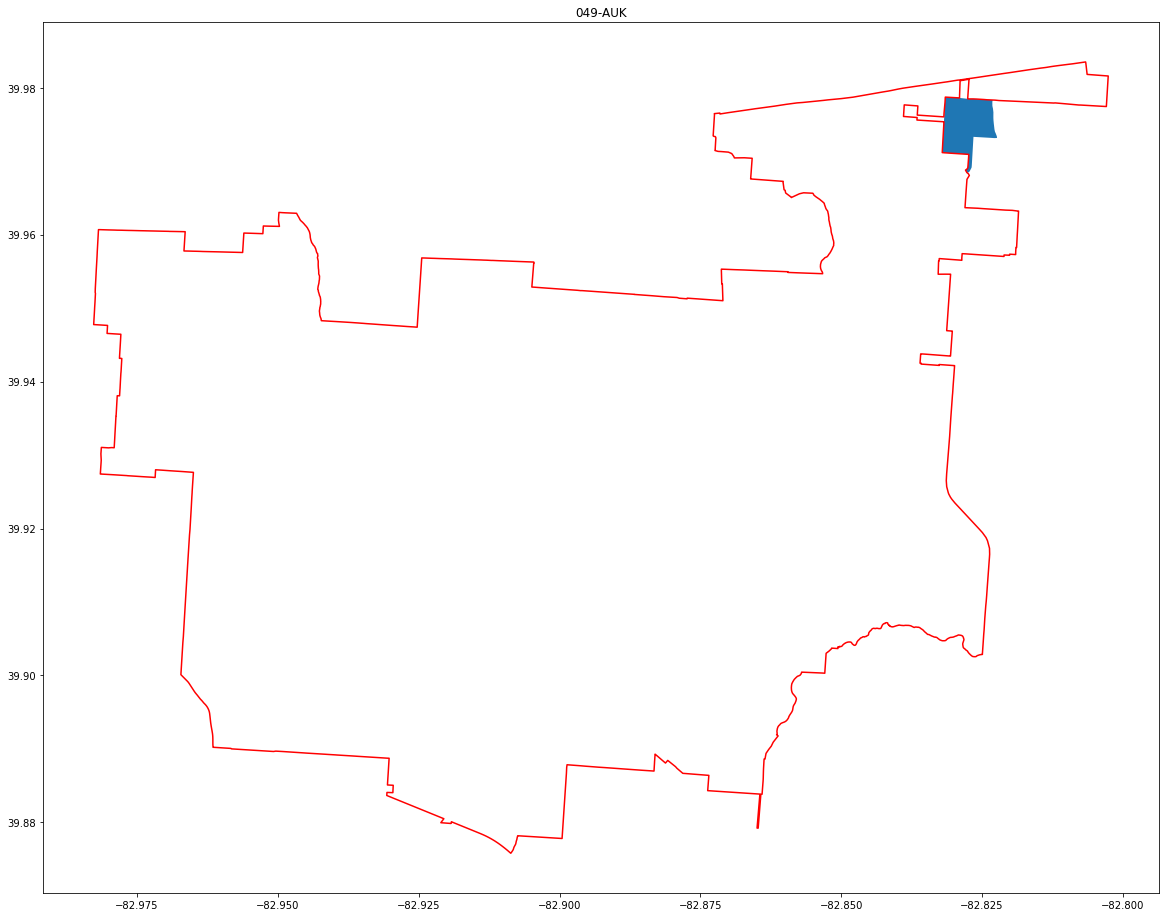

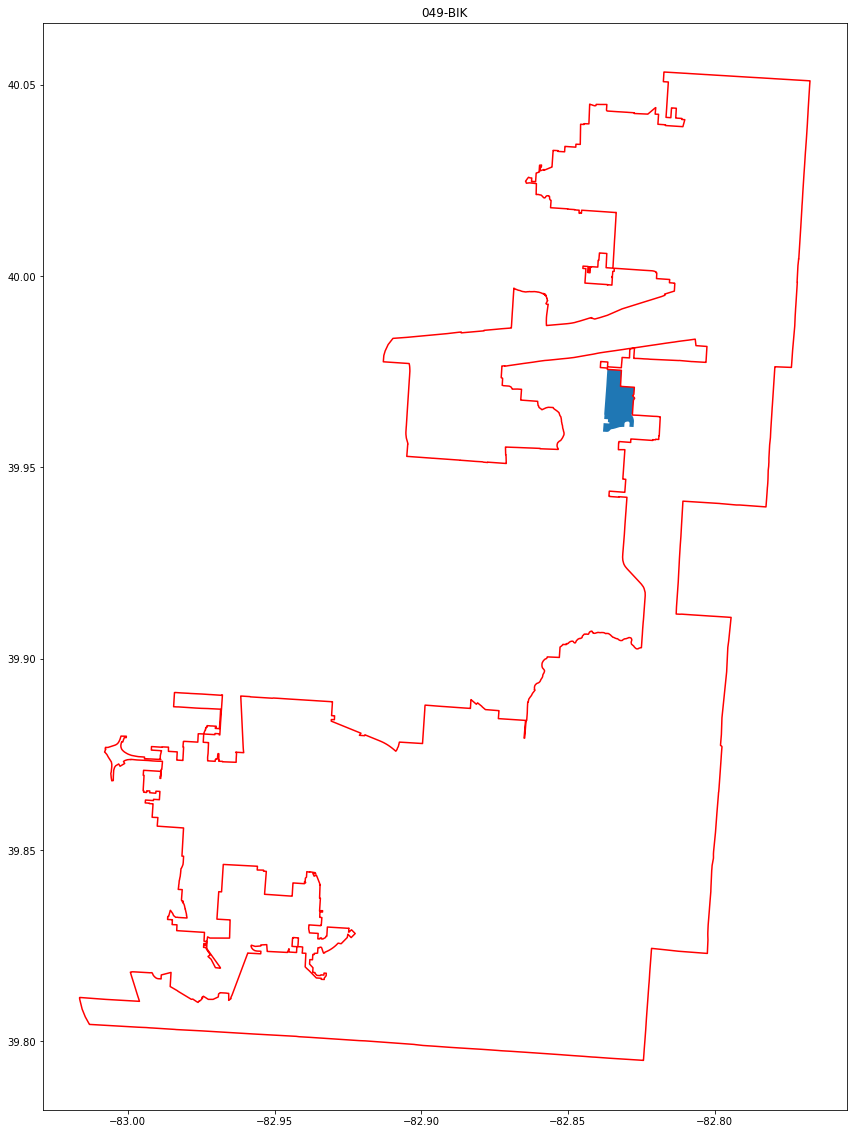

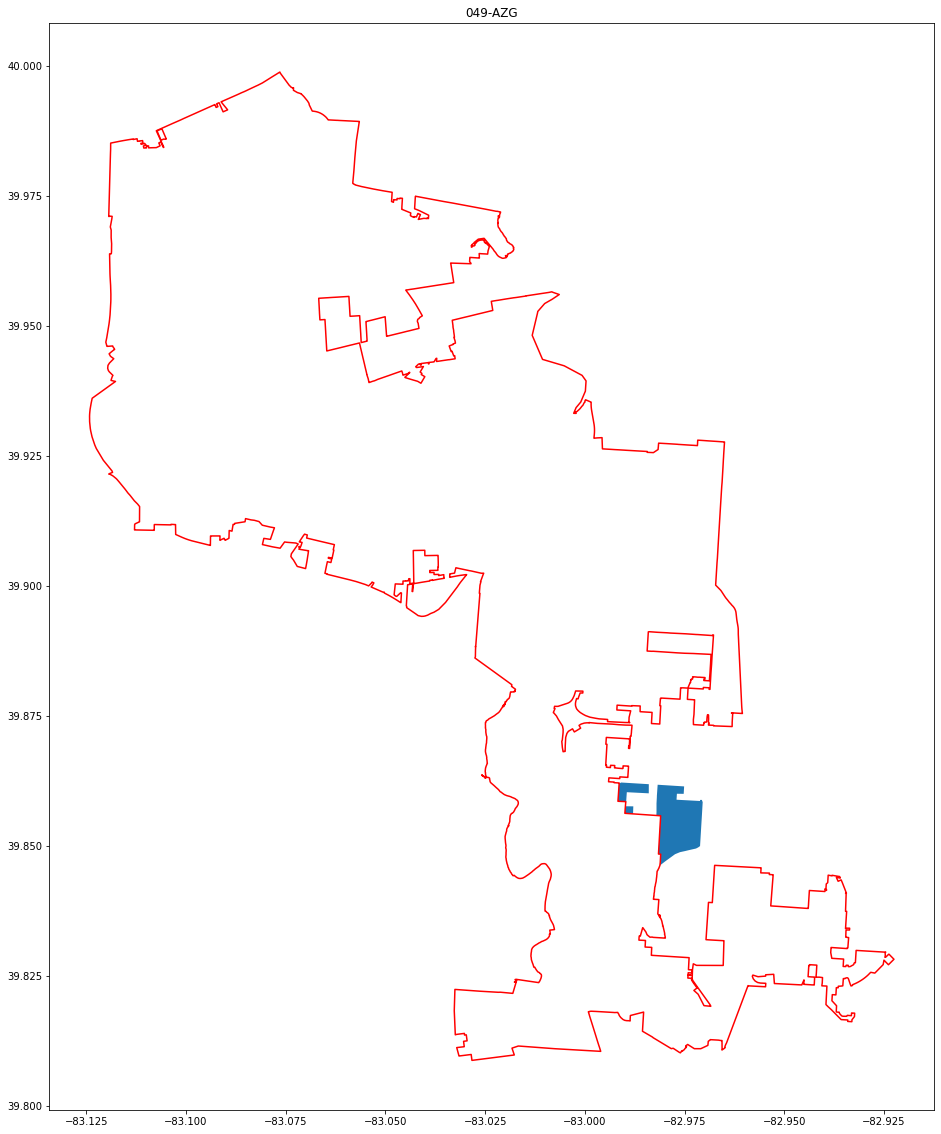

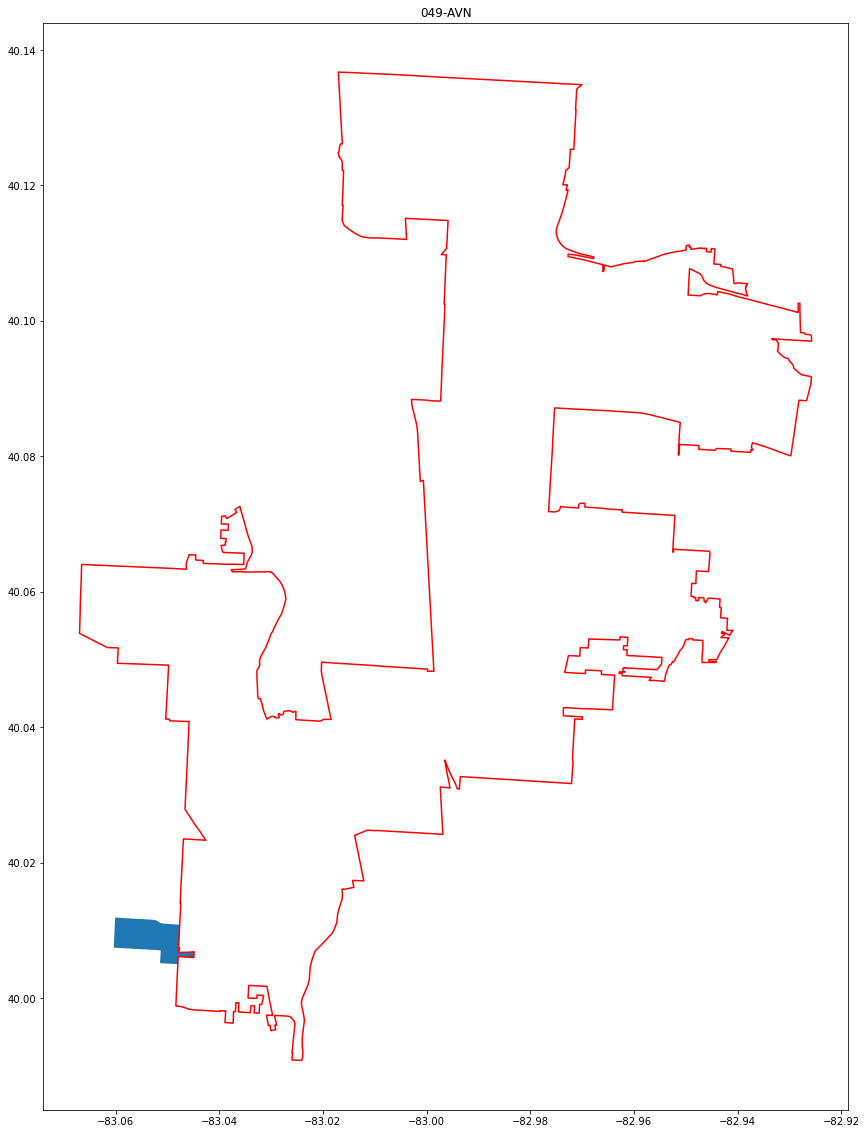

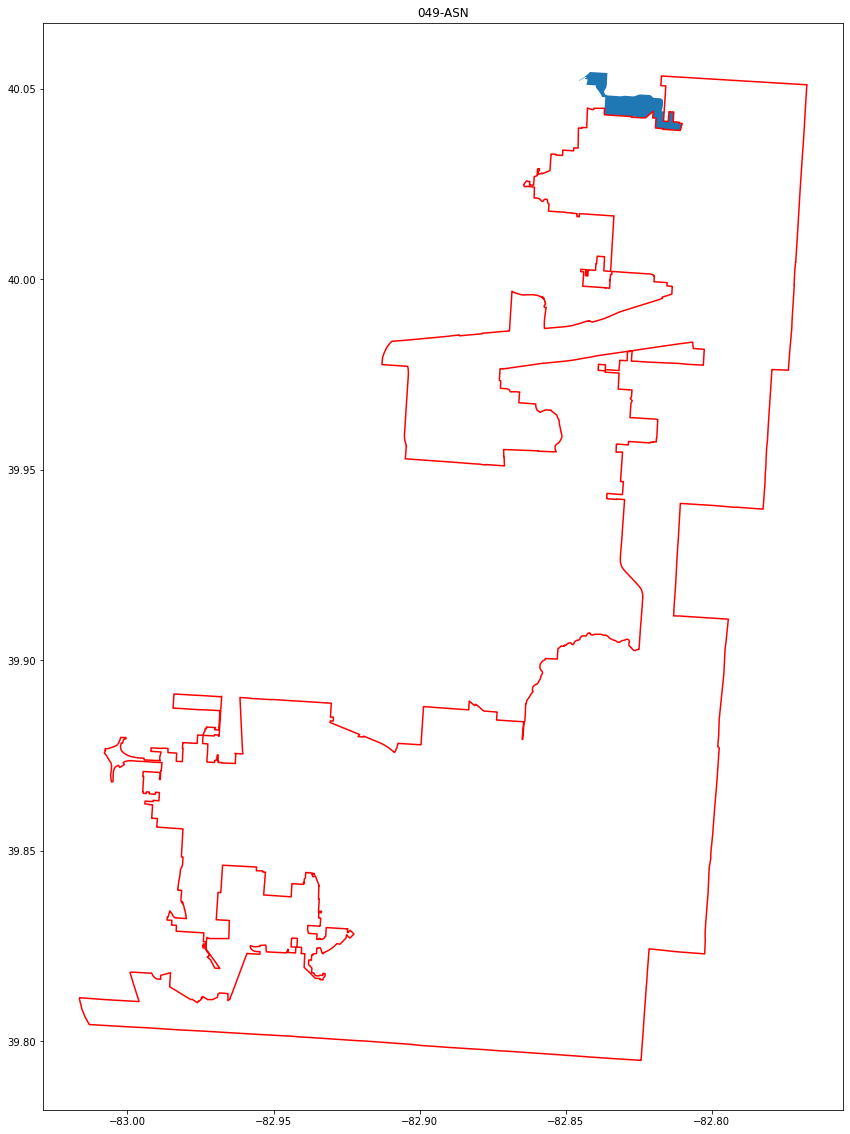

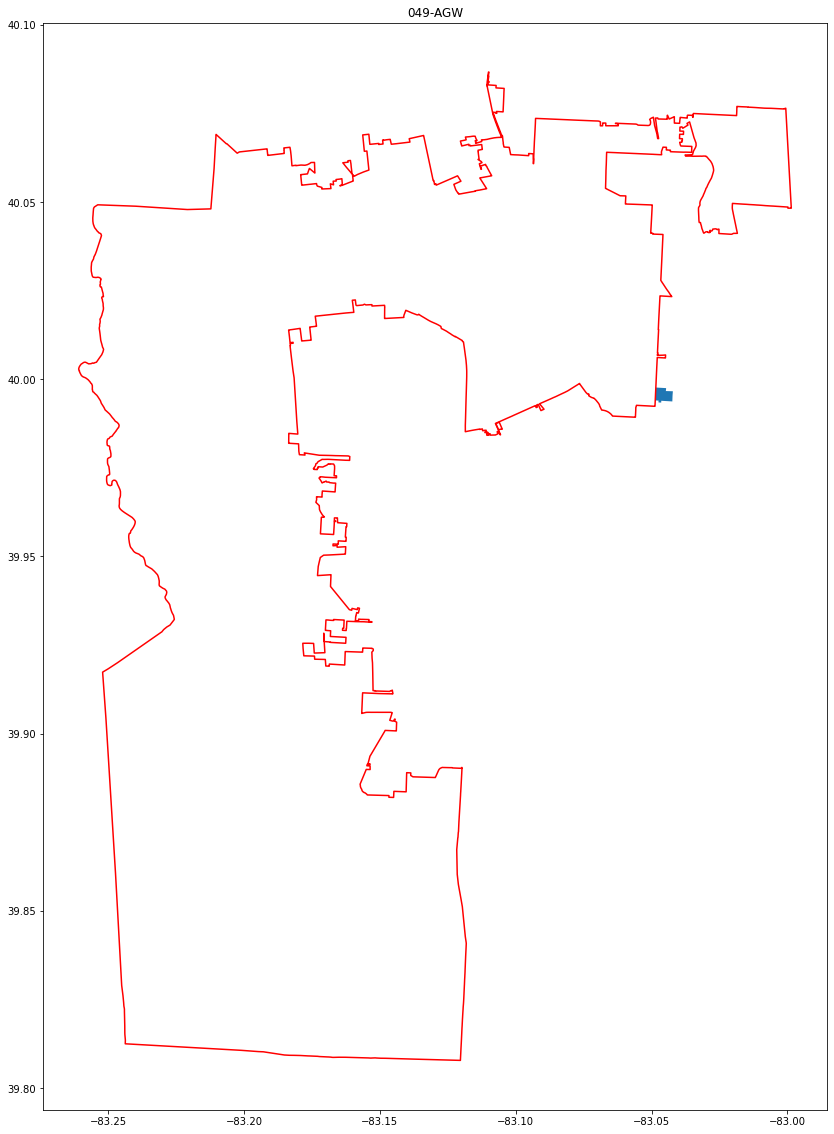

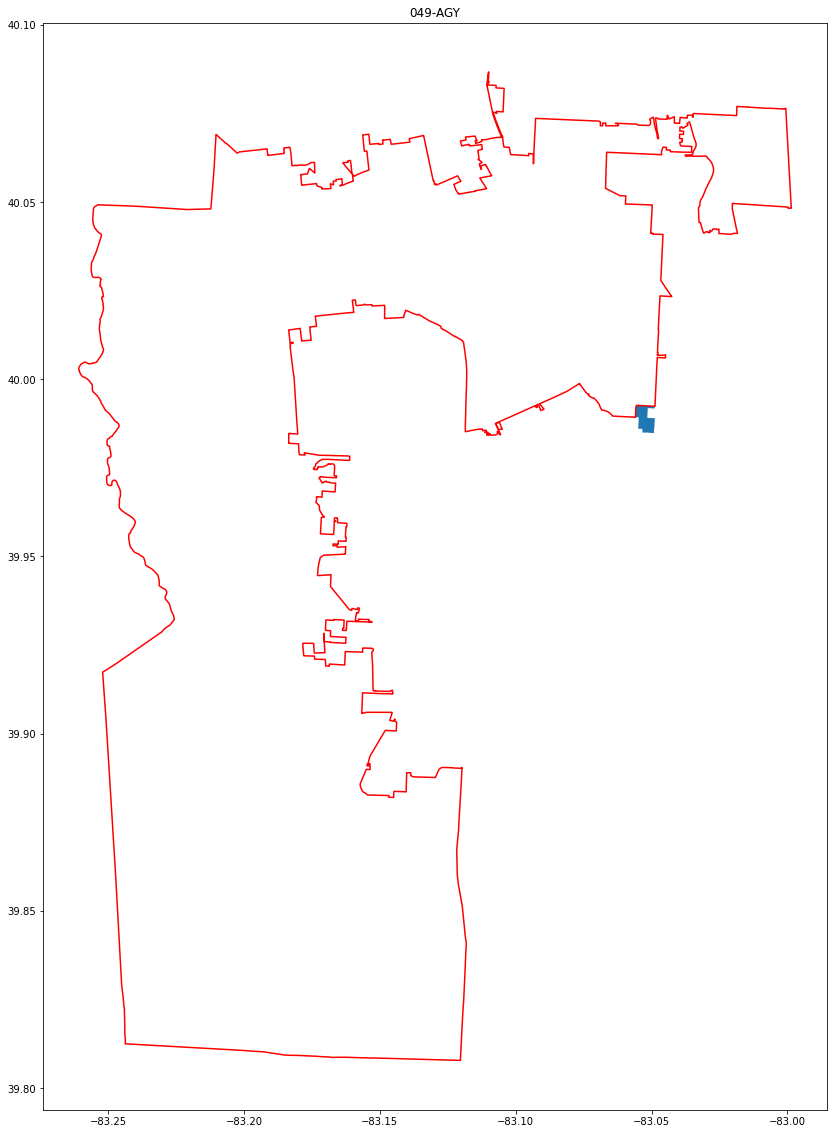

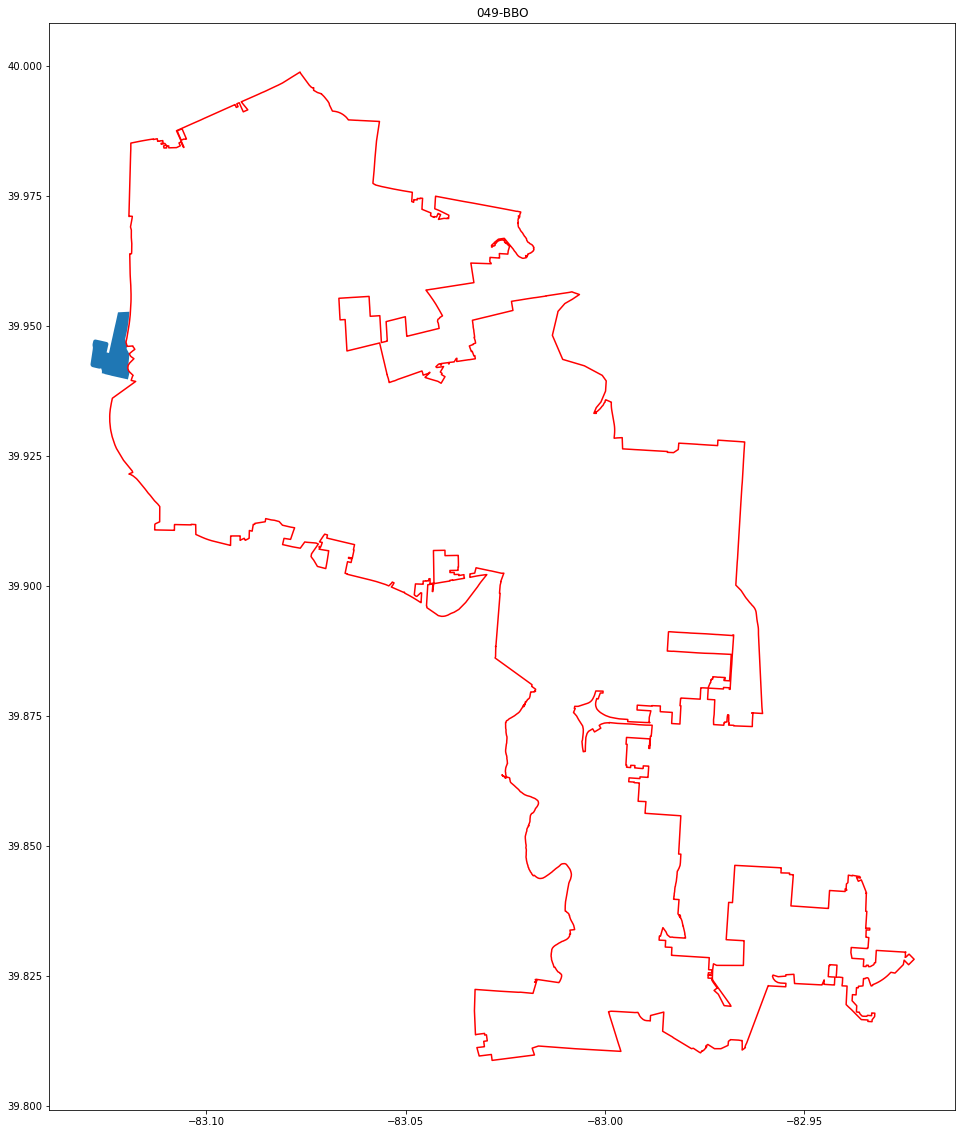

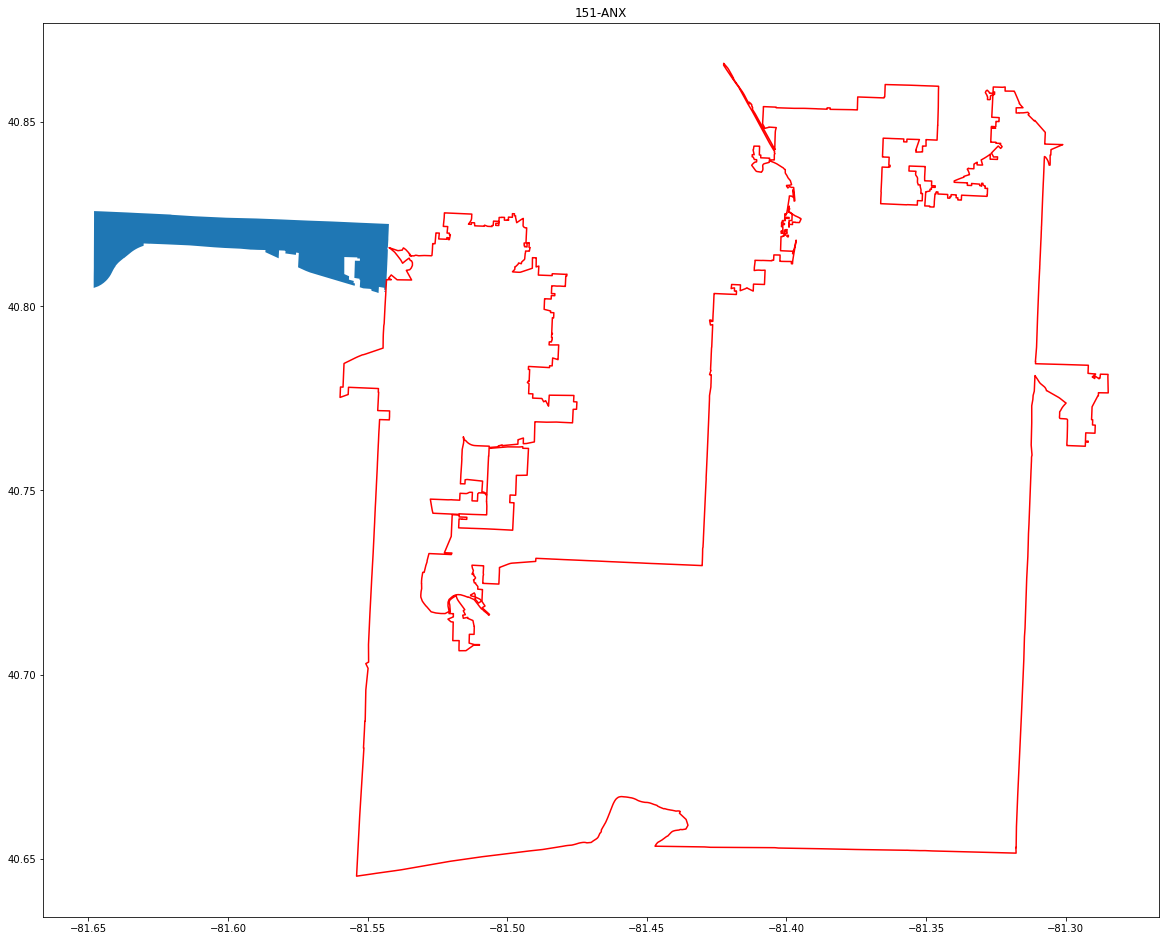

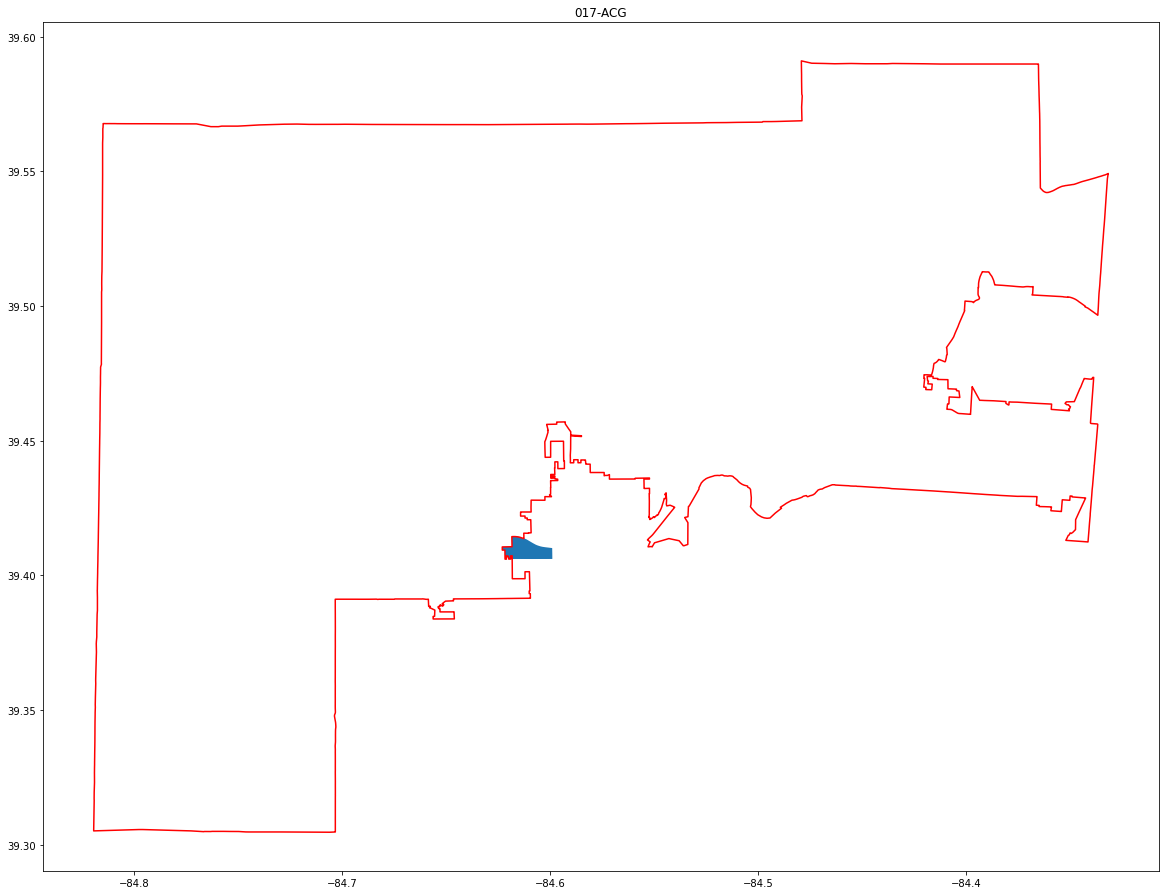

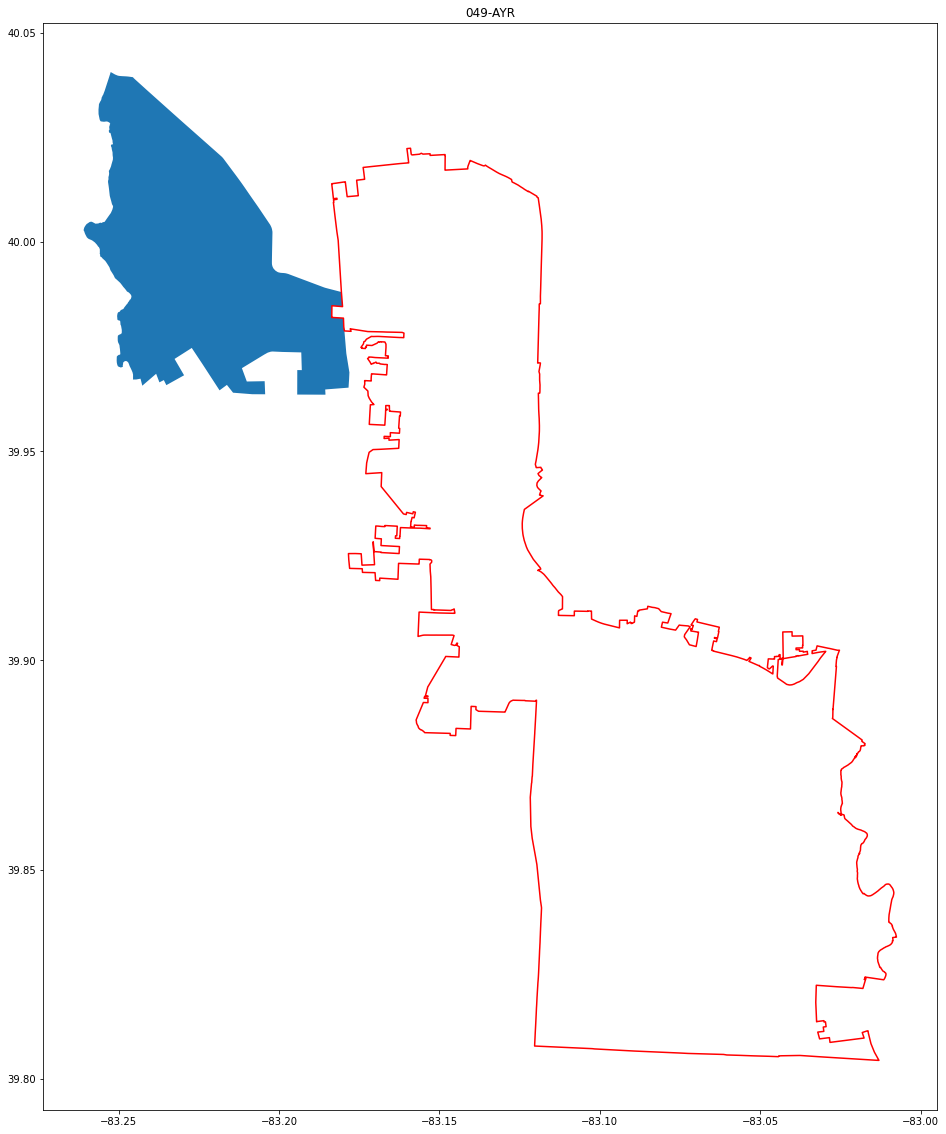

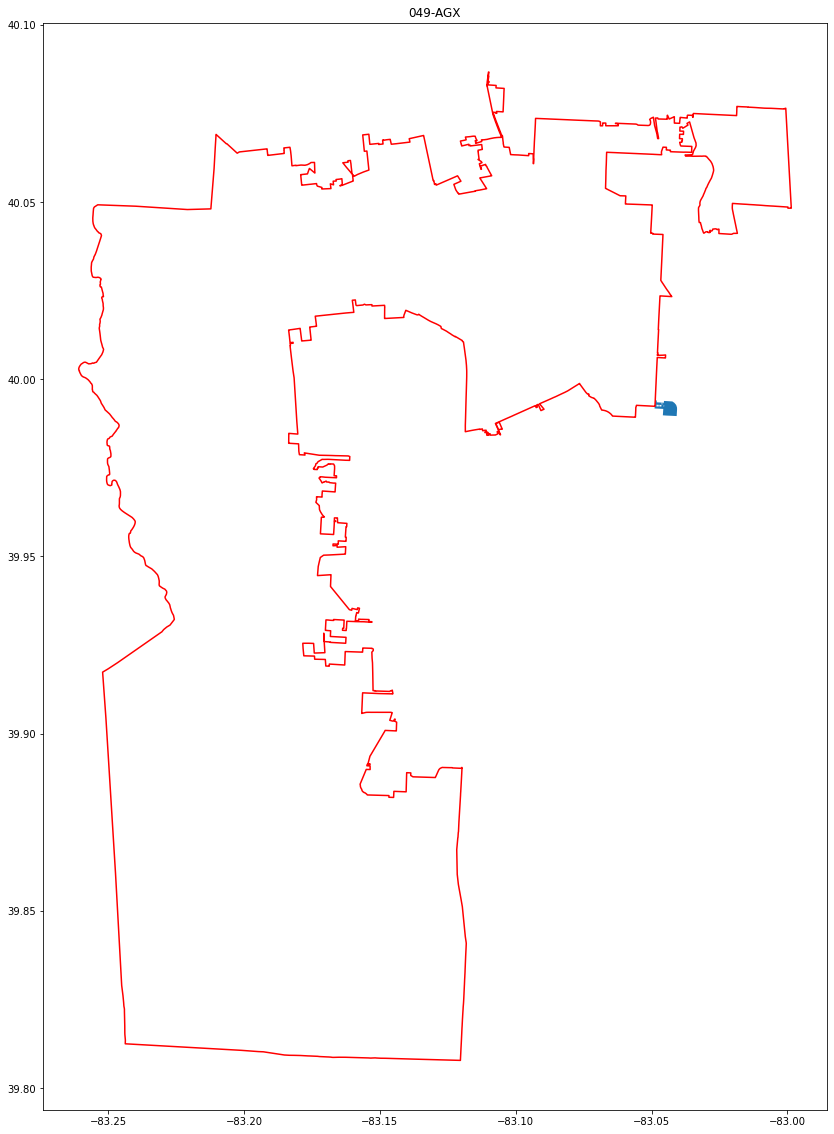

In [46]:
#Re-introduce the column from above

# Iterate over dataframe, get the results where splits will need to happen

for val in attempt_one["UNIQUE_ID"]:
    cd_list = []
    if val in sll_splits_dict.keys():
        #How we will actually call it
        cd_splits(sll_splits_dict[val],"SLL",val)

In [47]:
lost_sum = 0
for val in sorted(global_precinct_differences_dict.keys()):
    lost_sum += global_precinct_differences_dict[val]
    print(val, global_precinct_differences_dict[val])

GSL17DMIL 20
GSL17RHAS 9
GSL20DBRO 3
GSL20RBAE 3
GSL22DLEL 24
GSL23DDAY 0
GSL23RLAN 2
GSL24DRUS 56
GSL24RMAN 18
GSL25DJAR 37
GSL25RBUR 26
GSL26DCRA 15
GSL49DWES 6
GSL49RHAA 5
GSL53DNOV 6
GSL53RHAL 14
GSL85RVIT 14
GSL94DONE 7
GSL94REDW 1


In [48]:
pd.options.display.max_columns = 999

display(attempt_one[attempt_one["UNIQUE_ID"]=="049-BBR-(SLL-19)"])
display(attempt_one[attempt_one["UNIQUE_ID"]=="049-BBR-(SLL-21)"])
display(attempt_one[attempt_one["UNIQUE_ID"]=="049-BBR-(SLL-22)"])

,STATEFP20,COUNTYFP20,VTDST20,PRECINCT20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,geometry,UNIQUE_ID,County Name,Precinct Name,Precinct Code,Region Name,Media Market,Registered Voters,Ballots Counted,Official Voter Turnout,COUNTYFP,GSL01DTHE,GSL01RWIG,GSL02DGRA,GSL02RJOH,GSL03RGHA,GSL03DJOH,GSL04RCUP,GSL05RGIN,GSL05DWIN,GSL06RHAW,GSL06DROB,GSL07RPAT,GSL07DSWE,GSL08DSMI,GSL09DBOY,GSL09RRUS,GSL10DUPC,GSL11DHOW,GSL12DBRE,GSL12RPOW,GSL13RHAR,GSL13DSKI,GSL14RMCM,GSL14DSWE,GSL15DCRO,GSL15RKUS,GSL16RGRE,GSL16DSMI,GSL17RHAS,GSL17DMIL,GSL18DBOG,GSL18RPAC,GSL19RFRE,GSL19DLIG,GSL20RBAE,GSL20DBRO,GSL21RCOO,GSL21DLIS,GSL22DLEL,GSL23DDAY,GSL23RLAN,GSL24RMAN,GSL24DRUS,GSL25RBUR,GSL25DJAR,GSL26DCRA,GSL27DBIT,GSL27RBRI,GSL28DMIR,GSL28RMON,GSL29RABR,GSL30IROL,GSL30RSEI,GSL31DKEL,GSL32DING,GSL33DDEN,GSL33RHIL,GSL34DSYK,GSL34RTOD,GSL35DGAL,GSL35RSAR,GSL36DSHA,GSL36RYOU,GSL37RBIG,GSL37DWEI,GSL38DCAM,GSL38RROE,GSL39DBLA,GSL39RMUL,GSL40DJAC,GSL40RPLU,GSL41DBER,GSL41RWHI,GSL42RYOU,GSL43DCOX,GSL43RCRE,GSL44DHIC,GSL44RMCM,GSL45RLOG,GSL45DSOB,GSL46RSAL,GSL46DSHE,GSL47DLAR,GSL47RMER,GSL48ROEL,GSL49RHAA,GSL49DWES,GSL50DSIM,GSL50RSTO,GSL51RCAR,GSL52RGRO,GSL52DHOR,GSL53RHAL,GSL53DNOV,GSL54DSHO,GSL54RZEL,GSL55RMAN,GSL55DSTE,GSL56RLAC,GSL56DMIL,GSL57DADK,GSL57RSTE,GSL58DHAG,GSL58RSIM,GSL59RCUT,GSL59DSTA,GSL60RPHI,GSL60DTRO,GSL61RCAL,GSL61DDUD,GSL62RLIP,GSL62DROS,GSL63DBLA,GSL63RLOY,GSL64DOBR,GSL64RYOD,GSL65DDAR,GSL65RSCH,GSL66RBIR,GSL67RJOR,GSL67DMOR,GSL68RCAR,GSL68DMOU,GSL69DBEH,GSL69RRAY,GSL70DBAR,GSL70RKIC,GSL71DCAR,GSL71RFRA,GSL72RHOU,GSL73RLAM,GSL73DMCC,GSL74RDEA,GSL75DCLI,GSL75RPAV,GSL76RGRE,GSL76DWES,GSL77RLAR,GSL77DWIL,GSL78DOWE,GSL78RSTE,GSL79RKOE,GSL79DRIC,GSL80DJON,GSL80RPOW,GSL81RHOO,GSL82RRIE,GSL83RCRO,GSL84RMAN,GSL84DMON,GSL85RVIT,GSL86RRIC,GSL86DROB,GSL87DBAR,GSL87RMCC,GSL88RCLI,GSL88DLIE,GSL89DMIL,GSL89RSWE,GSL90RBAL,GSL91DDAI,GSL91RWIL,GSL92RJOH,GSL92DWOR,GSL93RSTE,GSL94REDW,GSL94DONE,GSL95RJON,GSL96RFER,GSL96LHER,GSL96DOLI,GSL97RHOL,GSL97DSWO,GSL98DBEE,GSL98RHIL,GSL99DDAN,GSL99RART,_merge
9040,39,049,025BBR,BBR,39049025BBR,SHARON-A,271,357,4,0,"MULTIPOLYGON (((-82.97384 40.11599, -82.97374 ...",049-BBR-(SLL-19),Franklin,SHARON-A,BBR,Central,Columbus,753,636,0.844622,049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,both


,STATEFP20,COUNTYFP20,VTDST20,PRECINCT20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,geometry,UNIQUE_ID,County Name,Precinct Name,Precinct Code,Region Name,Media Market,Registered Voters,Ballots Counted,Official Voter Turnout,COUNTYFP,GSL01DTHE,GSL01RWIG,GSL02DGRA,GSL02RJOH,GSL03RGHA,GSL03DJOH,GSL04RCUP,GSL05RGIN,GSL05DWIN,GSL06RHAW,GSL06DROB,GSL07RPAT,GSL07DSWE,GSL08DSMI,GSL09DBOY,GSL09RRUS,GSL10DUPC,GSL11DHOW,GSL12DBRE,GSL12RPOW,GSL13RHAR,GSL13DSKI,GSL14RMCM,GSL14DSWE,GSL15DCRO,GSL15RKUS,GSL16RGRE,GSL16DSMI,GSL17RHAS,GSL17DMIL,GSL18DBOG,GSL18RPAC,GSL19RFRE,GSL19DLIG,GSL20RBAE,GSL20DBRO,GSL21RCOO,GSL21DLIS,GSL22DLEL,GSL23DDAY,GSL23RLAN,GSL24RMAN,GSL24DRUS,GSL25RBUR,GSL25DJAR,GSL26DCRA,GSL27DBIT,GSL27RBRI,GSL28DMIR,GSL28RMON,GSL29RABR,GSL30IROL,GSL30RSEI,GSL31DKEL,GSL32DING,GSL33DDEN,GSL33RHIL,GSL34DSYK,GSL34RTOD,GSL35DGAL,GSL35RSAR,GSL36DSHA,GSL36RYOU,GSL37RBIG,GSL37DWEI,GSL38DCAM,GSL38RROE,GSL39DBLA,GSL39RMUL,GSL40DJAC,GSL40RPLU,GSL41DBER,GSL41RWHI,GSL42RYOU,GSL43DCOX,GSL43RCRE,GSL44DHIC,GSL44RMCM,GSL45RLOG,GSL45DSOB,GSL46RSAL,GSL46DSHE,GSL47DLAR,GSL47RMER,GSL48ROEL,GSL49RHAA,GSL49DWES,GSL50DSIM,GSL50RSTO,GSL51RCAR,GSL52RGRO,GSL52DHOR,GSL53RHAL,GSL53DNOV,GSL54DSHO,GSL54RZEL,GSL55RMAN,GSL55DSTE,GSL56RLAC,GSL56DMIL,GSL57DADK,GSL57RSTE,GSL58DHAG,GSL58RSIM,GSL59RCUT,GSL59DSTA,GSL60RPHI,GSL60DTRO,GSL61RCAL,GSL61DDUD,GSL62RLIP,GSL62DROS,GSL63DBLA,GSL63RLOY,GSL64DOBR,GSL64RYOD,GSL65DDAR,GSL65RSCH,GSL66RBIR,GSL67RJOR,GSL67DMOR,GSL68RCAR,GSL68DMOU,GSL69DBEH,GSL69RRAY,GSL70DBAR,GSL70RKIC,GSL71DCAR,GSL71RFRA,GSL72RHOU,GSL73RLAM,GSL73DMCC,GSL74RDEA,GSL75DCLI,GSL75RPAV,GSL76RGRE,GSL76DWES,GSL77RLAR,GSL77DWIL,GSL78DOWE,GSL78RSTE,GSL79RKOE,GSL79DRIC,GSL80DJON,GSL80RPOW,GSL81RHOO,GSL82RRIE,GSL83RCRO,GSL84RMAN,GSL84DMON,GSL85RVIT,GSL86RRIC,GSL86DROB,GSL87DBAR,GSL87RMCC,GSL88RCLI,GSL88DLIE,GSL89DMIL,GSL89RSWE,GSL90RBAL,GSL91DDAI,GSL91RWIL,GSL92RJOH,GSL92DWOR,GSL93RSTE,GSL94REDW,GSL94DONE,GSL95RJON,GSL96RFER,GSL96LHER,GSL96DOLI,GSL97RHOL,GSL97DSWO,GSL98DBEE,GSL98RHIL,GSL99DDAN,GSL99RART,_merge
9041,39,049,025BBR,BBR,39049025BBR,SHARON-A,271,357,4,0,"MULTIPOLYGON (((-83.04134 40.12544, -83.04128 ...",049-BBR-(SLL-21),Franklin,SHARON-A,BBR,Central,Columbus,753,636,0.844622,049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,217,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,both


,STATEFP20,COUNTYFP20,VTDST20,PRECINCT20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,geometry,UNIQUE_ID,County Name,Precinct Name,Precinct Code,Region Name,Media Market,Registered Voters,Ballots Counted,Official Voter Turnout,COUNTYFP,GSL01DTHE,GSL01RWIG,GSL02DGRA,GSL02RJOH,GSL03RGHA,GSL03DJOH,GSL04RCUP,GSL05RGIN,GSL05DWIN,GSL06RHAW,GSL06DROB,GSL07RPAT,GSL07DSWE,GSL08DSMI,GSL09DBOY,GSL09RRUS,GSL10DUPC,GSL11DHOW,GSL12DBRE,GSL12RPOW,GSL13RHAR,GSL13DSKI,GSL14RMCM,GSL14DSWE,GSL15DCRO,GSL15RKUS,GSL16RGRE,GSL16DSMI,GSL17RHAS,GSL17DMIL,GSL18DBOG,GSL18RPAC,GSL19RFRE,GSL19DLIG,GSL20RBAE,GSL20DBRO,GSL21RCOO,GSL21DLIS,GSL22DLEL,GSL23DDAY,GSL23RLAN,GSL24RMAN,GSL24DRUS,GSL25RBUR,GSL25DJAR,GSL26DCRA,GSL27DBIT,GSL27RBRI,GSL28DMIR,GSL28RMON,GSL29RABR,GSL30IROL,GSL30RSEI,GSL31DKEL,GSL32DING,GSL33DDEN,GSL33RHIL,GSL34DSYK,GSL34RTOD,GSL35DGAL,GSL35RSAR,GSL36DSHA,GSL36RYOU,GSL37RBIG,GSL37DWEI,GSL38DCAM,GSL38RROE,GSL39DBLA,GSL39RMUL,GSL40DJAC,GSL40RPLU,GSL41DBER,GSL41RWHI,GSL42RYOU,GSL43DCOX,GSL43RCRE,GSL44DHIC,GSL44RMCM,GSL45RLOG,GSL45DSOB,GSL46RSAL,GSL46DSHE,GSL47DLAR,GSL47RMER,GSL48ROEL,GSL49RHAA,GSL49DWES,GSL50DSIM,GSL50RSTO,GSL51RCAR,GSL52RGRO,GSL52DHOR,GSL53RHAL,GSL53DNOV,GSL54DSHO,GSL54RZEL,GSL55RMAN,GSL55DSTE,GSL56RLAC,GSL56DMIL,GSL57DADK,GSL57RSTE,GSL58DHAG,GSL58RSIM,GSL59RCUT,GSL59DSTA,GSL60RPHI,GSL60DTRO,GSL61RCAL,GSL61DDUD,GSL62RLIP,GSL62DROS,GSL63DBLA,GSL63RLOY,GSL64DOBR,GSL64RYOD,GSL65DDAR,GSL65RSCH,GSL66RBIR,GSL67RJOR,GSL67DMOR,GSL68RCAR,GSL68DMOU,GSL69DBEH,GSL69RRAY,GSL70DBAR,GSL70RKIC,GSL71DCAR,GSL71RFRA,GSL72RHOU,GSL73RLAM,GSL73DMCC,GSL74RDEA,GSL75DCLI,GSL75RPAV,GSL76RGRE,GSL76DWES,GSL77RLAR,GSL77DWIL,GSL78DOWE,GSL78RSTE,GSL79RKOE,GSL79DRIC,GSL80DJON,GSL80RPOW,GSL81RHOO,GSL82RRIE,GSL83RCRO,GSL84RMAN,GSL84DMON,GSL85RVIT,GSL86RRIC,GSL86DROB,GSL87DBAR,GSL87RMCC,GSL88RCLI,GSL88DLIE,GSL89DMIL,GSL89RSWE,GSL90RBAL,GSL91DDAI,GSL91RWIL,GSL92RJOH,GSL92DWOR,GSL93RSTE,GSL94REDW,GSL94DONE,GSL95RJON,GSL96RFER,GSL96LHER,GSL96DOLI,GSL97RHOL,GSL97DSWO,GSL98DBEE,GSL98RHIL,GSL99DDAN,GSL99RART,_merge
9042,39,049,025BBR,BBR,39049025BBR,SHARON-A,271,357,4,0,"MULTIPOLYGON (((-82.95811 40.09849, -82.95806 ...",049-BBR-(SLL-22),Franklin,SHARON-A,BBR,Central,Columbus,753,636,0.844622,049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,both


In [49]:
tot_sum = 0
for val in final_races:
    tot_sum += sum(attempt_one[val])
    print(val, sum(attempt_one[val]))

GSL01DTHE 15836
GSL01RWIG 36730
GSL02DGRA 16440
GSL02RJOH 41102
GSL03RGHA 37677
GSL03DJOH 27094
GSL04RCUP 38882
GSL05RGIN 36243
GSL05DWIN 12554
GSL06RHAW 35982
GSL06DROB 37995
GSL07RPAT 37493
GSL07DSWE 26922
GSL08DSMI 41159
GSL09DBOY 50894
GSL09RRUS 7868
GSL10DUPC 28453
GSL11DHOW 27346
GSL12DBRE 43247
GSL12RPOW 9342
GSL13RHAR 11621
GSL13DSKI 33647
GSL14RMCM 19643
GSL14DSWE 27618
GSL15DCRO 24020
GSL15RKUS 22018
GSL16RGRE 34075
GSL16DSMI 35013
GSL17RHAS 16579
GSL17DMIL 21644
GSL18DBOG 45861
GSL18RPAC 13007
GSL19RFRE 32950
GSL19DLIG 42267
GSL20RBAE 24925
GSL20DBRO 36327
GSL21RCOO 32756
GSL21DLIS 42990
GSL22DLEL 45730
GSL23DDAY 27532
GSL23RLAN 34273
GSL24RMAN 31184
GSL24DRUS 42879
GSL25RBUR 8844
GSL25DJAR 41275
GSL26DCRA 45335
GSL27DBIT 33339
GSL27RBRI 37723
GSL28DMIR 35353
GSL28RMON 33039
GSL29RABR 43320
GSL30IROL 16426
GSL30RSEI 42269
GSL31DKEL 42180
GSL32DING 42055
GSL33DDEN 41500
GSL33RHIL 13901
GSL34DSYK 36251
GSL34RTOD 10926
GSL35DGAL 22341
GSL35RSAR 17210
GSL36DSHA 29441
GSL36RYOU 3

In [50]:
tot_sum + lost_sum

5444983

5444983 as the total sum matches

### Note: Checked these totals on 02/02/22 and they MATCH what the state has here: https://www.sos.state.oh.us/elections/election-results-and-data/

## Add in a SLL_DIST column

In [51]:
attempt_one["Tot_Votes"] = 0

for race in final_races:
    attempt_one["Tot_Votes"] += attempt_one[race]

In [52]:
def contains_sll(dist_list):
    #print("Calling on ", dist_list)
    for dist_tuple in dist_list:
        #print("Call on ", dist_tuple)
        if dist_tuple[0] == "SL":
            #print("Found the SL")
            return dist_tuple[1]

In [53]:
check_list = {i:contains_sll(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

In [54]:
attempt_one["SLDL_DIST"] = attempt_one["UNIQUE_ID"].map(check_list).fillna("n/a")

In [55]:
attempt_one["SLDL_DIST"].value_counts(dropna=False)

n/a    257
90     128
96     127
93     119
95     118
      ... 
15      71
35      70
01      67
71      67
17      56
Name: SLDL_DIST, Length: 100, dtype: int64

In [56]:
attempt_one["SLDL_DIST"] = np.where((attempt_one["SLDL_DIST"]=="n/a") & (attempt_one["PRECINCT20"]!="ZZZ") & (attempt_one["Tot_Votes"] > 0),attempt_one["UNIQUE_ID"].str[-3:-1],attempt_one["SLDL_DIST"])

In [57]:
attempt_one["SLDL_DIST"].value_counts()

90     129
96     127
93     120
95     119
59     113
      ... 
29      73
17      72
71      69
01      67
n/a      8
Name: SLDL_DIST, Length: 100, dtype: int64

In [58]:
attempt_one[attempt_one["UNIQUE_ID"]=="011-AAR"]

,STATEFP20,COUNTYFP20,VTDST20,PRECINCT20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,geometry,UNIQUE_ID,County Name,Precinct Name,Precinct Code,Region Name,Media Market,Registered Voters,Ballots Counted,Official Voter Turnout,COUNTYFP,GSL01DTHE,GSL01RWIG,GSL02DGRA,GSL02RJOH,GSL03RGHA,GSL03DJOH,GSL04RCUP,GSL05RGIN,GSL05DWIN,GSL06RHAW,GSL06DROB,GSL07RPAT,GSL07DSWE,GSL08DSMI,GSL09DBOY,GSL09RRUS,GSL10DUPC,GSL11DHOW,GSL12DBRE,GSL12RPOW,GSL13RHAR,GSL13DSKI,GSL14RMCM,GSL14DSWE,GSL15DCRO,GSL15RKUS,GSL16RGRE,GSL16DSMI,GSL17RHAS,GSL17DMIL,GSL18DBOG,GSL18RPAC,GSL19RFRE,GSL19DLIG,GSL20RBAE,GSL20DBRO,GSL21RCOO,GSL21DLIS,GSL22DLEL,GSL23DDAY,GSL23RLAN,GSL24RMAN,GSL24DRUS,GSL25RBUR,GSL25DJAR,GSL26DCRA,GSL27DBIT,GSL27RBRI,GSL28DMIR,GSL28RMON,GSL29RABR,GSL30IROL,GSL30RSEI,GSL31DKEL,GSL32DING,GSL33DDEN,GSL33RHIL,GSL34DSYK,GSL34RTOD,GSL35DGAL,GSL35RSAR,GSL36DSHA,GSL36RYOU,GSL37RBIG,GSL37DWEI,GSL38DCAM,GSL38RROE,GSL39DBLA,GSL39RMUL,GSL40DJAC,GSL40RPLU,GSL41DBER,GSL41RWHI,GSL42RYOU,GSL43DCOX,GSL43RCRE,GSL44DHIC,GSL44RMCM,GSL45RLOG,GSL45DSOB,GSL46RSAL,GSL46DSHE,GSL47DLAR,GSL47RMER,GSL48ROEL,GSL49RHAA,GSL49DWES,GSL50DSIM,GSL50RSTO,GSL51RCAR,GSL52RGRO,GSL52DHOR,GSL53RHAL,GSL53DNOV,GSL54DSHO,GSL54RZEL,GSL55RMAN,GSL55DSTE,GSL56RLAC,GSL56DMIL,GSL57DADK,GSL57RSTE,GSL58DHAG,GSL58RSIM,GSL59RCUT,GSL59DSTA,GSL60RPHI,GSL60DTRO,GSL61RCAL,GSL61DDUD,GSL62RLIP,GSL62DROS,GSL63DBLA,GSL63RLOY,GSL64DOBR,GSL64RYOD,GSL65DDAR,GSL65RSCH,GSL66RBIR,GSL67RJOR,GSL67DMOR,GSL68RCAR,GSL68DMOU,GSL69DBEH,GSL69RRAY,GSL70DBAR,GSL70RKIC,GSL71DCAR,GSL71RFRA,GSL72RHOU,GSL73RLAM,GSL73DMCC,GSL74RDEA,GSL75DCLI,GSL75RPAV,GSL76RGRE,GSL76DWES,GSL77RLAR,GSL77DWIL,GSL78DOWE,GSL78RSTE,GSL79RKOE,GSL79DRIC,GSL80DJON,GSL80RPOW,GSL81RHOO,GSL82RRIE,GSL83RCRO,GSL84RMAN,GSL84DMON,GSL85RVIT,GSL86RRIC,GSL86DROB,GSL87DBAR,GSL87RMCC,GSL88RCLI,GSL88DLIE,GSL89DMIL,GSL89RSWE,GSL90RBAL,GSL91DDAI,GSL91RWIL,GSL92RJOH,GSL92DWOR,GSL93RSTE,GSL94REDW,GSL94DONE,GSL95RJON,GSL96RFER,GSL96LHER,GSL96DOLI,GSL97RHOL,GSL97DSWO,GSL98DBEE,GSL98RHIL,GSL99DDAN,GSL99RART,_merge,Tot_Votes,SLDL_DIST


In [59]:
attempt_one.drop("_merge", axis = 1, inplace = True)

In [60]:
oh_sll_districts["SLDL_DIST"] = oh_sll_districts["SLDLST"]
oh_sll_districts = oh_sll_districts[oh_sll_districts["SLDL_DIST"]!="ZZ"]

In [61]:
filtered_results = attempt_one[attempt_one["SLDL_DIST"] != "n/a"].dissolve("SLDL_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [62]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
    if (left_geoms.is_valid==False).any():
        raise ValueError
    elif(right_geoms.is_valid==False).any():
        raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 99 precincts for differences of greater than 0.1 km^2

1) For 49 difference in area is 0.3305312954035028
2) For 79 difference in area is 0.4450829905614866
3) For 64 difference in area is 0.11119134799268872
4) For 20 difference in area is 0.10465602941367666
5) For 72 difference in area is 0.6104530497920434
6) For 84 difference in area is 0.22729244725217163
7) For 70 difference in area is 0.12905818581201667
8) For 23 difference in area is 0.12544568498420938
9) For 13 difference in area is 1.1681334096583145
10) For 82 difference in area is 0.1519055096347626
11) For 83 difference in area is 0.10340429253885673
12) For 51 difference in area is 0.1151306909225853
13) For 10 difference in area is 1.6614355144121975
14) For 08 difference in area is 0.38217343936205883
15) For 86 difference in area is 0.17225841200682965
16) For 48 difference in area is 0.3117994361180094
17) For 71 difference in area is 0.6104530497920433
18) For 76 difference in area is 5.558684306386967
19

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


23) For 75 difference in area is 8.97748678651051
24) For 87 difference in area is 0.20603113424953617
25) For 43 difference in area is 0.10091410528625382
26) For 69 difference in area is 0.12905818581201667
27) For 89 difference in area is 4.162675127829893
28) For 95 difference in area is 0.12441598770278293
29) For 74 difference in area is 0.5117366538973939
30) For 30 difference in area is 0.3814549768562415
31) For 52 difference in area is 0.39887286781577314
32) For 78 difference in area is 0.11898685002039226
33) For 53 difference in area is 0.3552449582354744
34) For 42 difference in area is 0.10384284592905738
35) For 99 difference in area is 0.15590285976273555
36) For 11 difference in area is 0.1500750926965547
37) For 32 difference in area is 0.36323537752155655
38) For 18 difference in area is 0.19185082805860035
39) For 41 difference in area is 0.13112022215309033
40) For 16 difference in area is 1.5650244794179573

Scroll down to see plots of any differences

Of the 99 

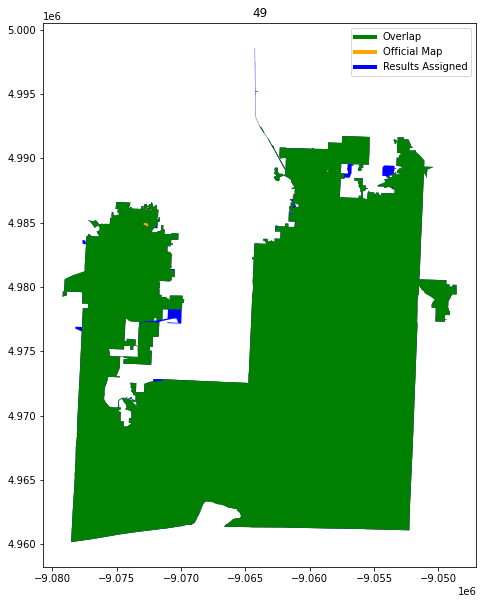

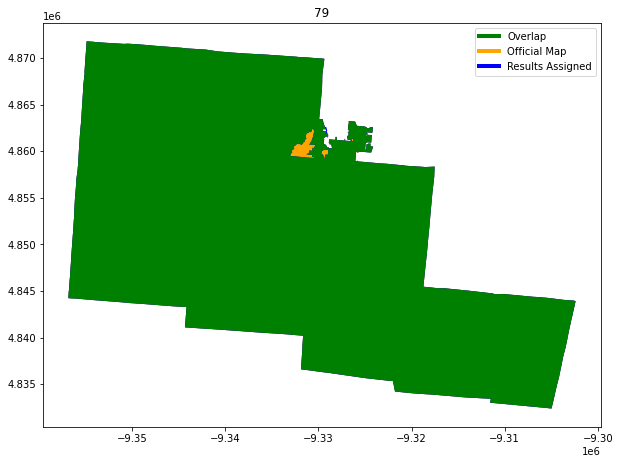

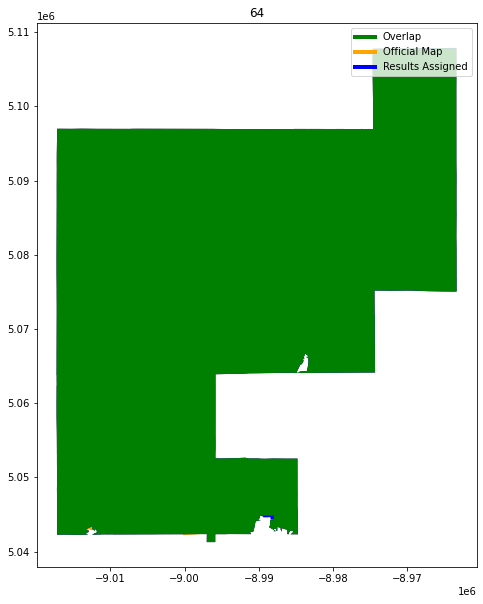

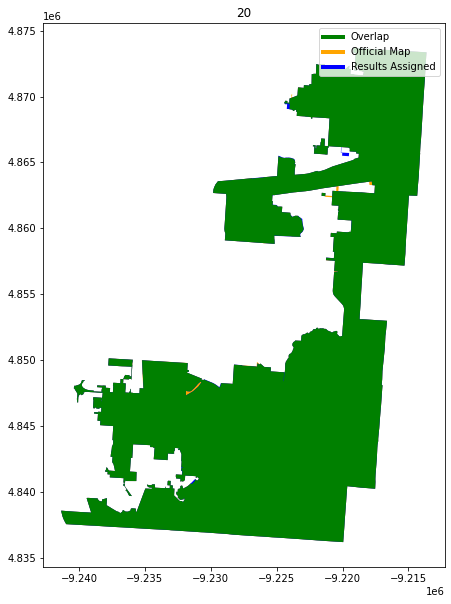

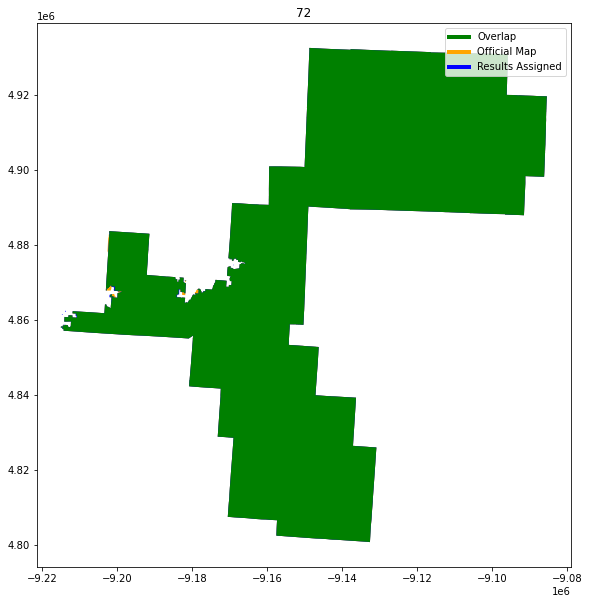

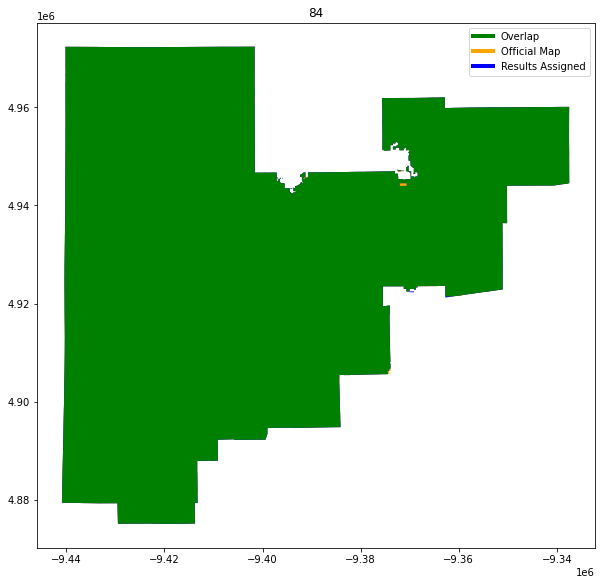

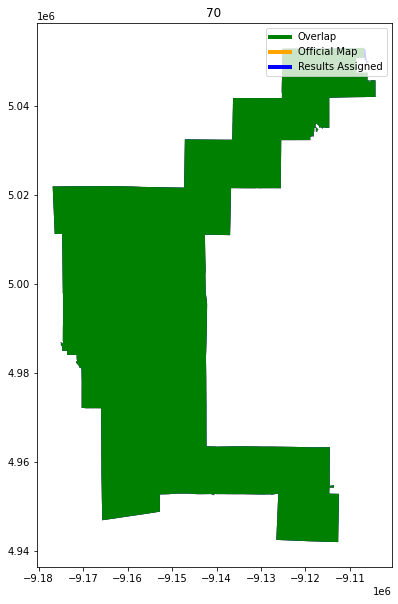

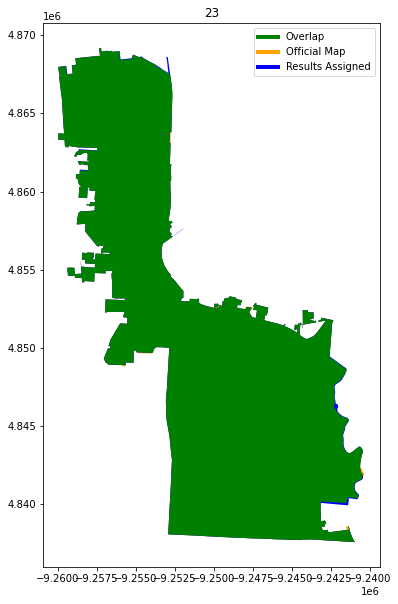

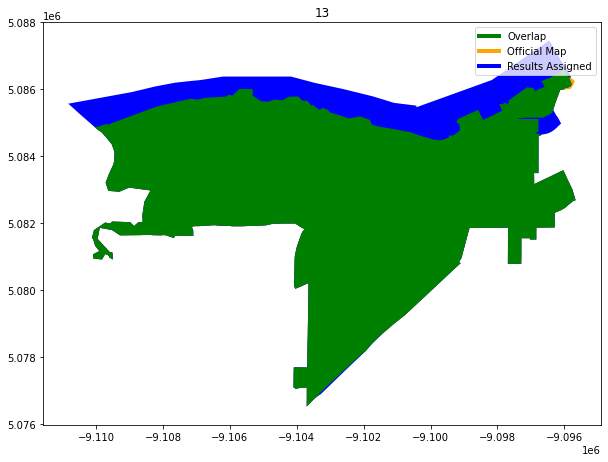

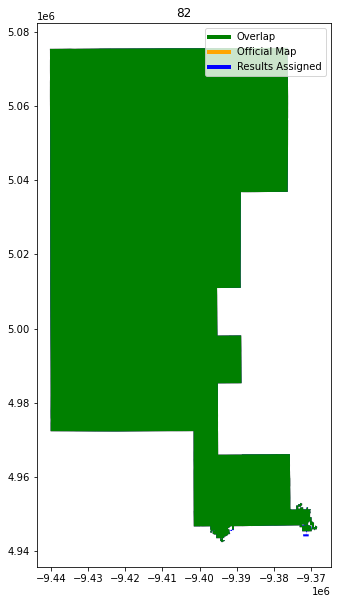

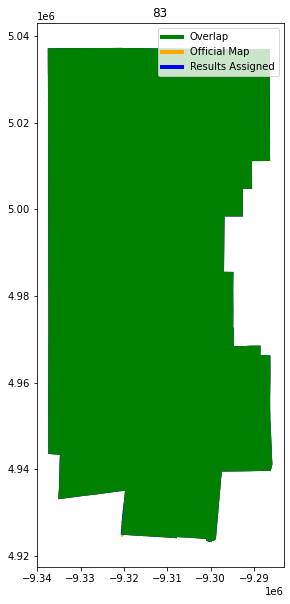

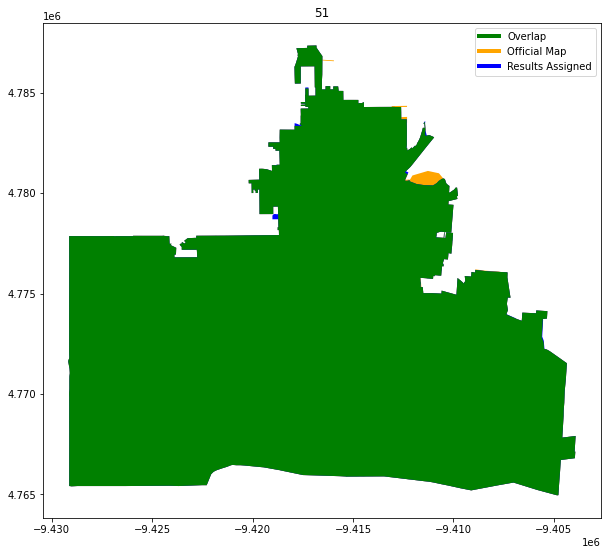

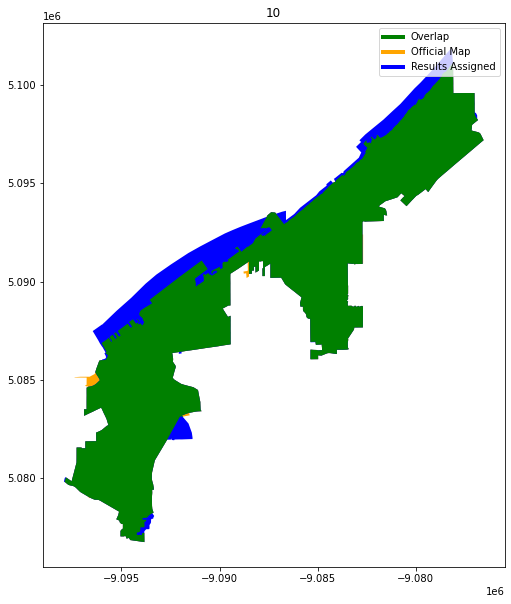

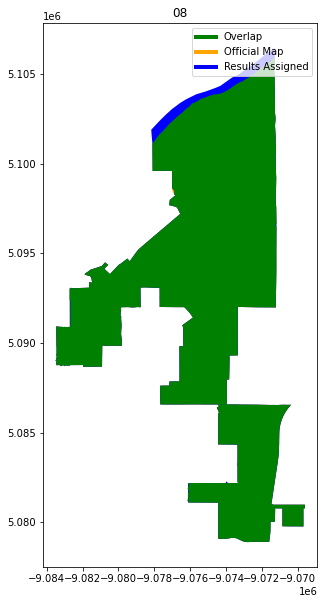

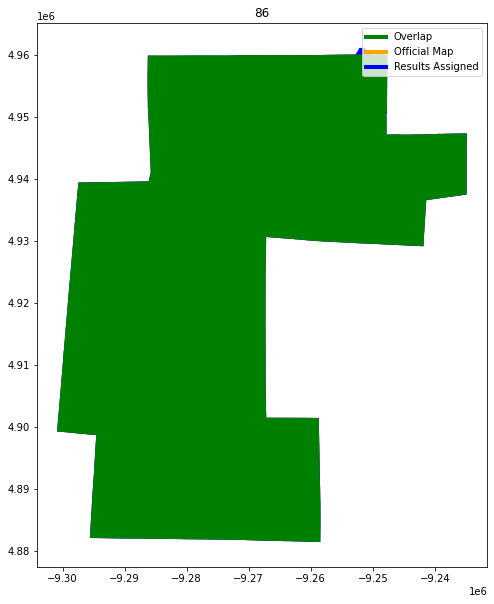

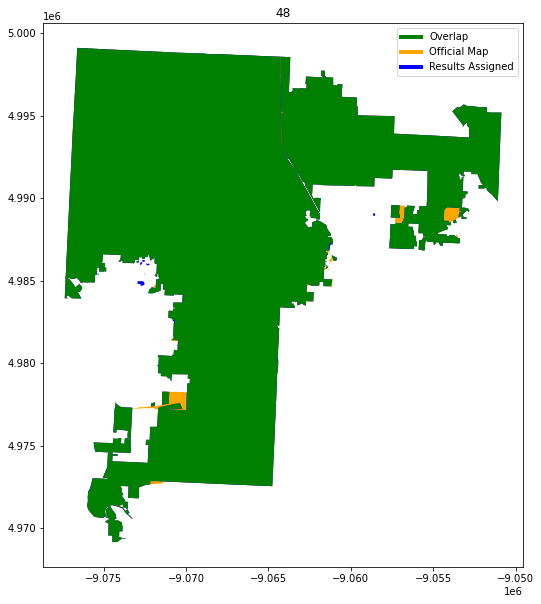

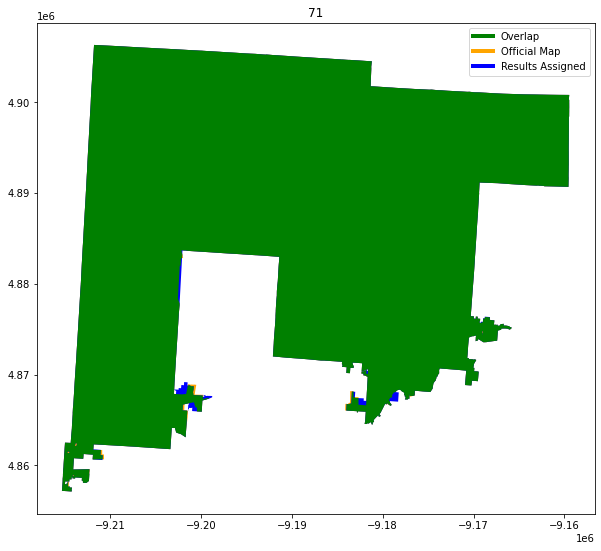

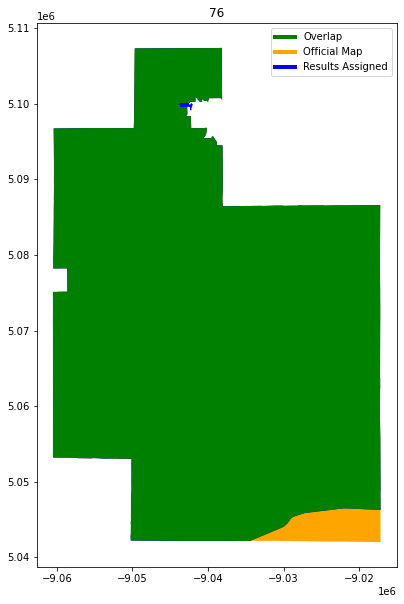

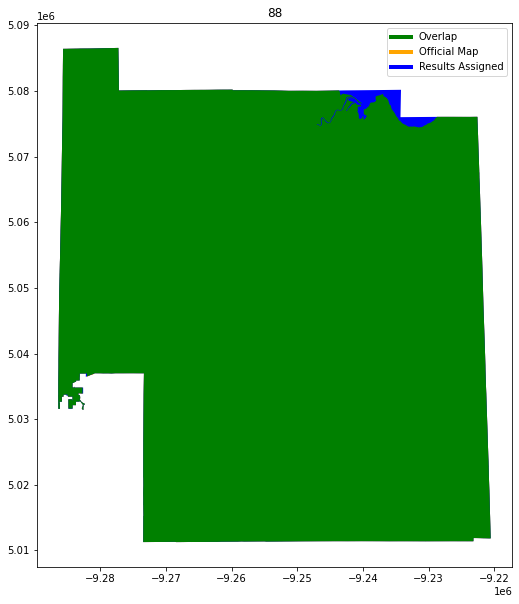

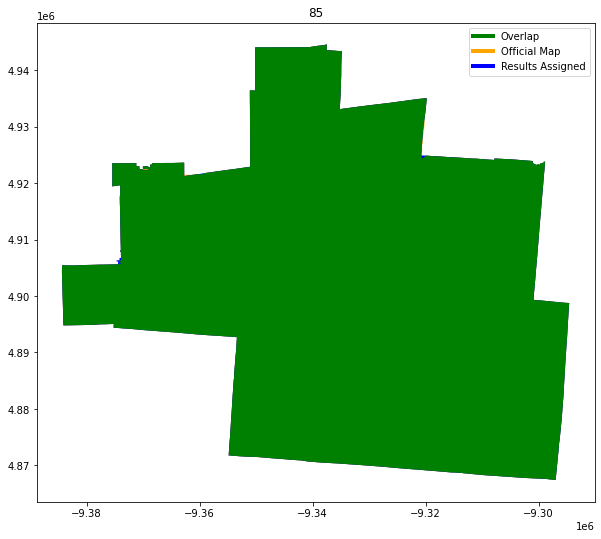

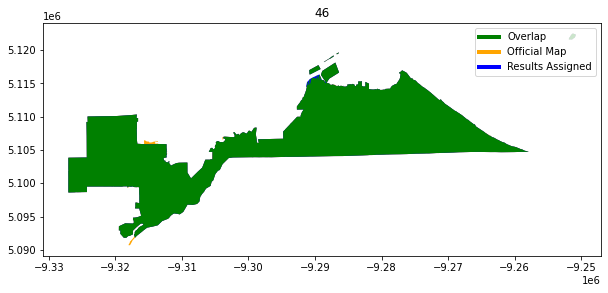

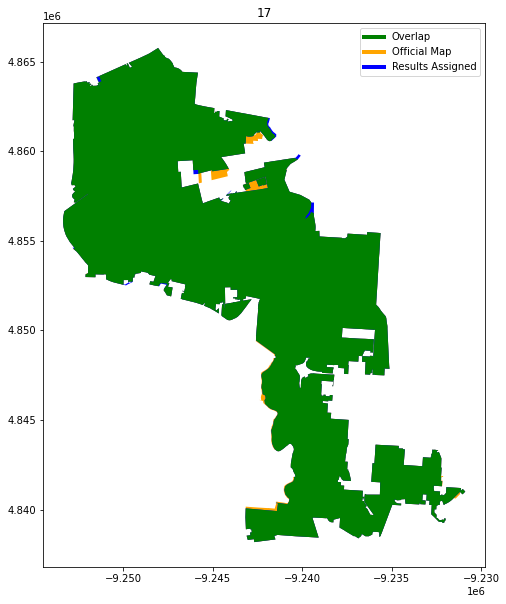

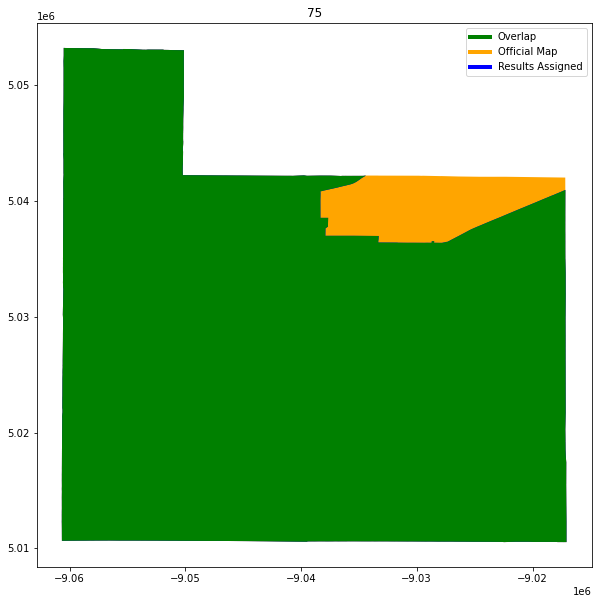

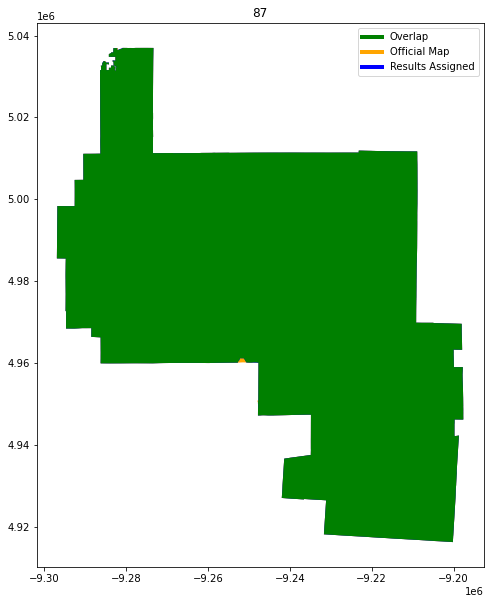

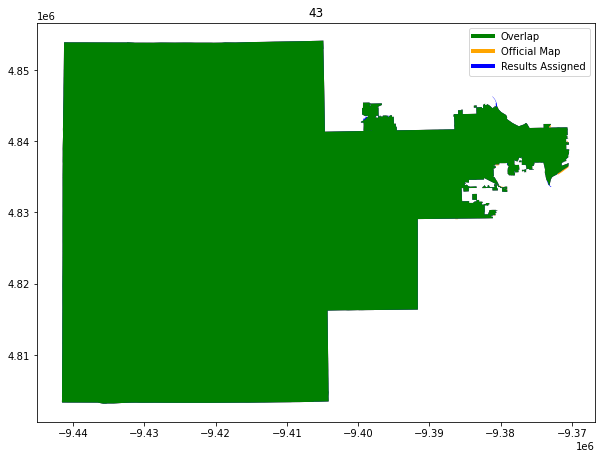

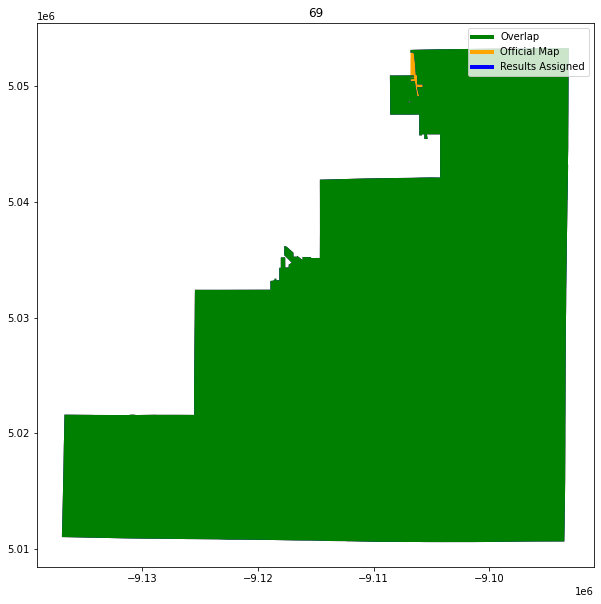

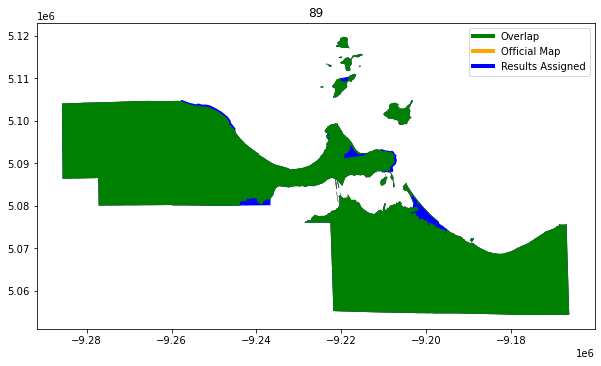

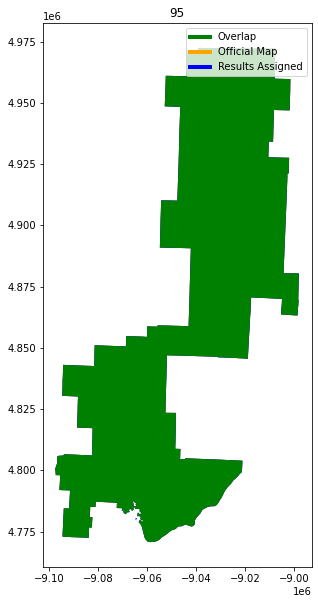

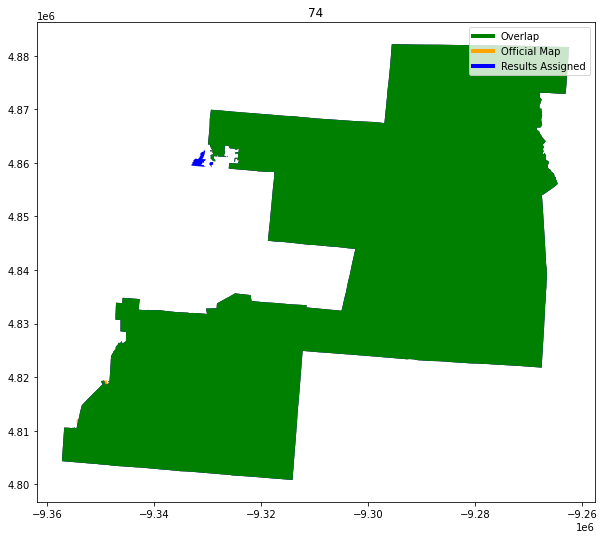

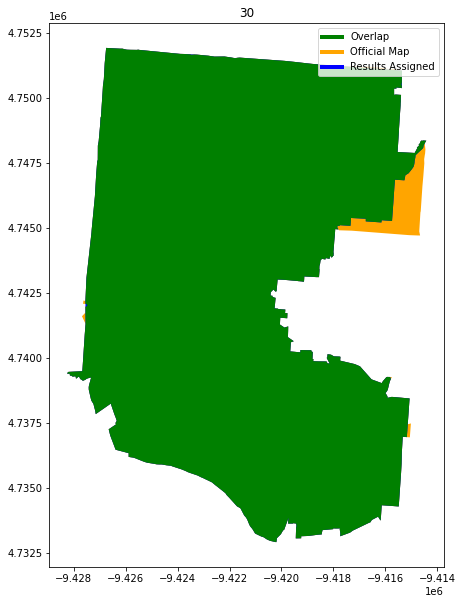

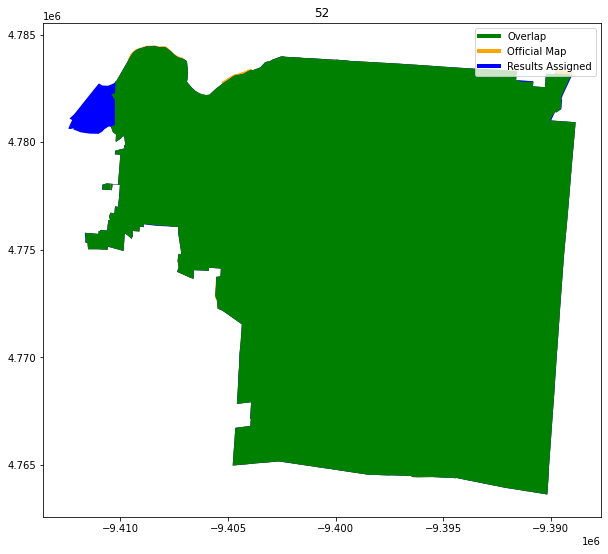

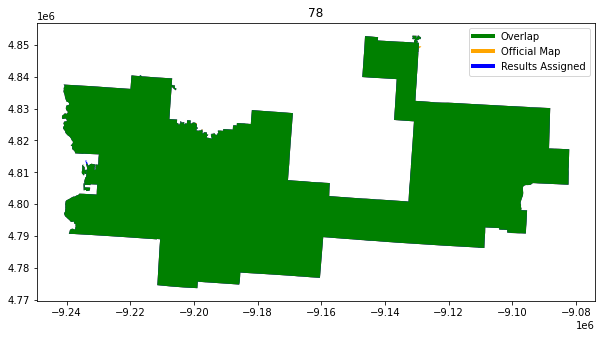

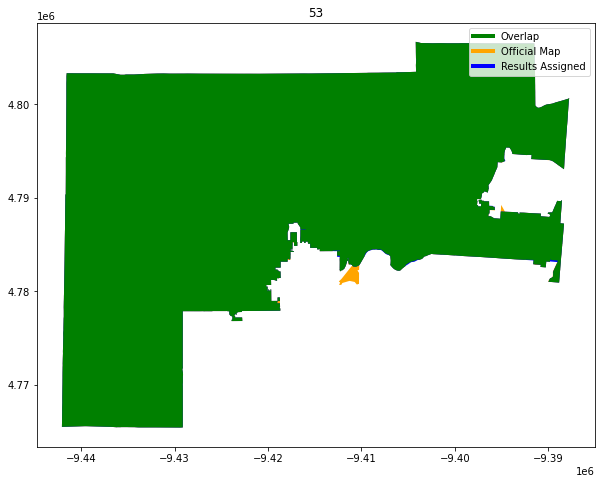

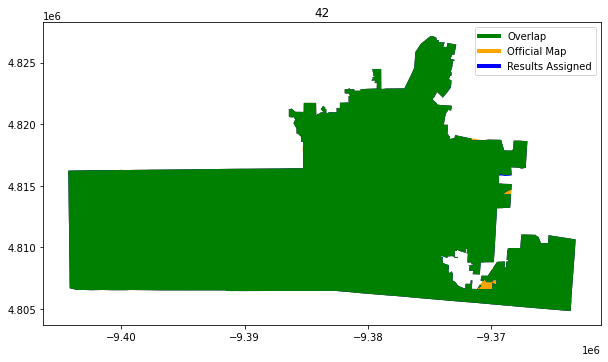

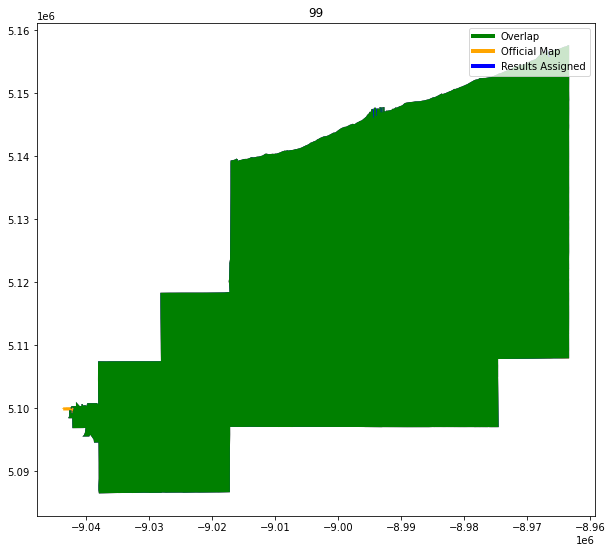

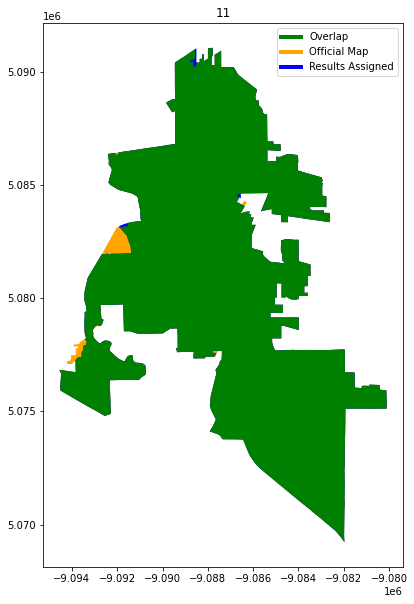

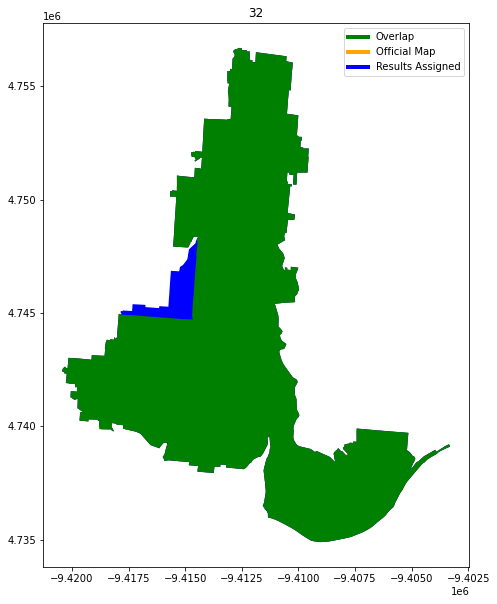

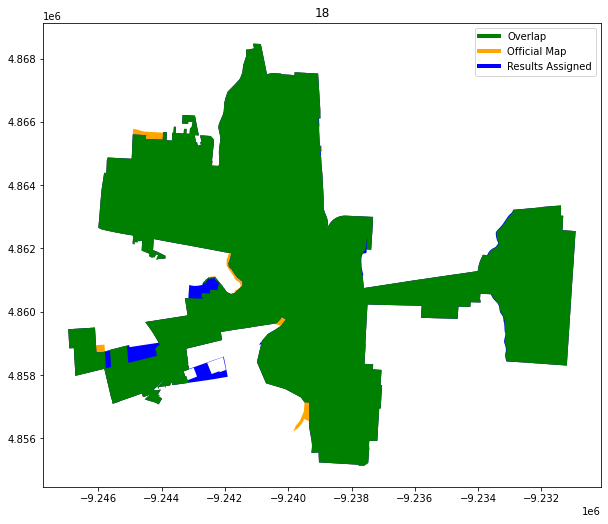

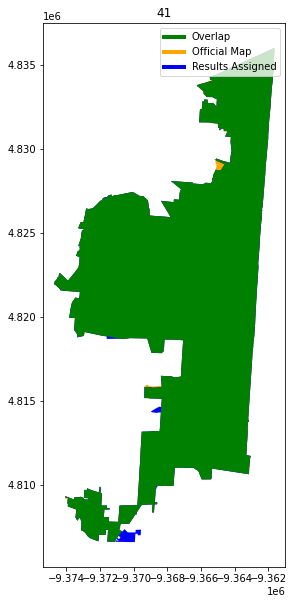

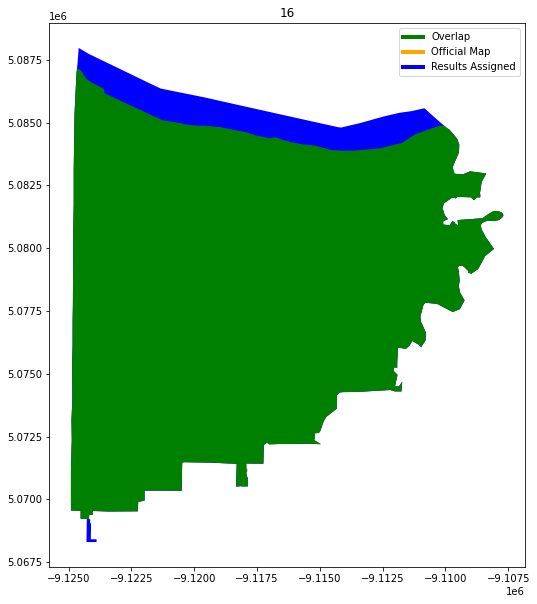

In [63]:
compare_geometries(oh_sll_districts,filtered_results,"Official Map","Results Assigned","SLDL_DIST",area_threshold=.1)

## Sort the columns to match what VEST has

In [64]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry',
       'UNIQUE_ID'],
      dtype='object')

In [65]:
attempt_one.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW',
       ...
       'GSL96LHER', 'GSL96DOLI', 'GSL97RHOL', 'GSL97DSWO', 'GSL98DBEE',
       'GSL98RHIL', 'GSL99DDAN', 'GSL99RART', 'Tot_Votes', 'SLDL_DIST'],
      dtype='object', length=200)

In [66]:
attempt_one.rename(columns={'Registered Voters':'REG_VOTERS'},inplace=True)

In [67]:
attempt_one = attempt_one[["UNIQUE_ID","COUNTYFP",'STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20','SLDL_DIST']+
                         final_races+["geometry"]]

In [68]:
attempt_one.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'STATEFP20', 'COUNTYFP20', 'VTDST20',
       'PRECINCT20', 'GEOID20', 'NAME20', 'SLDL_DIST', 'GSL01DTHE',
       ...
       'GSL96RFER', 'GSL96LHER', 'GSL96DOLI', 'GSL97RHOL', 'GSL97DSWO',
       'GSL98DBEE', 'GSL98RHIL', 'GSL99DDAN', 'GSL99RART', 'geometry'],
      dtype='object', length=187)

In [69]:
if not os.path.exists('./oh_gen_20_prec/'):
    os.mkdir('./oh_gen_20_prec/')

attempt_one.to_file('./oh_gen_20_prec/oh_gen_20_sldl_prec.shp')